# CONTENT

[CONFIGURATION](#configuration) 

[MAIN FUNCTION](#main_function)

[MODEL](#model)

[EXECUTION](#execution)

# **LIBRARIES**

In [1]:
import os
import tempfile
import gc
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from glob import glob
from pathlib import Path
from datetime import datetime
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve, auc
import sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from tqdm.notebook import tqdm
import joblib
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)




import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
2024-04-15 10:07:48.696799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 10:07:48.696902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 10:07:48.809045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **CONFIGURATION**
<a id='configuration'></a>

[CONFIGURATION](#configuration) 

[MAIN FUNCTION](#main_function)

[MODEL](#model)

[EXECUTION](#execution)

In [2]:
# GENERAL CONFIGURATIONS
NUM_THREADS = 4
DATA_DIRECTORY = "/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/"
SUBMISSION_SUFIX = "_model_2.1_31"
#MODE CONFIGURATION
SHOW_REPORT = False
SELECTKBEST = False
EXPORT_DATAFRAME = False
IMPORT_DATAFRAME = False
# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS
GENERATE_SUBMISSION_FILES = True
EVALUATE_VALIDATION_SET = True
STRATIFIED_KFOLD = True
BALANCE_COLUMNS = False
RANDOM_SEED = 2024
NUM_FOLDS = 4
EARLY_STOPPING = 100
EPOCHS = 100
BATCH_SIZE = 2048
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")



### Set aggregations

In [3]:
APPLPREV1_AGG = {

    'num_group1':['count'],
    'actualdpd_943P': ['mean','last'],
    'annuity_853A': ['max','mean','last'],
    'approvaldate_319D':['max','mean','last'],
    'byoccupationinc_3656910L': ['max'],
    'cancelreason_3545846M':['max','last'],
    'childnum_21L': ['max'],
    'creationdate_885D':['mean','last'],
   # 'credacc_actualbalance_314A': ['min','max','mean','sum'],
    'credacc_credlmt_575A': ['max','mean','last'],
 #   'credacc_maxhisbal_375A': ['min','max','mean','sum'],
  #  'credacc_minhisbal_90A': ['min','max','mean','sum'],
    'credacc_status_367L': ['max'],
  #  'credacc_transactions_402L': ['min','max','mean','sum'],
    'credamount_590A': ['max','mean','last'],
    'credtype_587L': ['max','last'],
    'currdebt_94A': ['max','mean','last'],
    'dateactivated_425D':['max','mean','last'],
    'district_544M':['max'],
    'downpmt_134A': ['max','mean','last'],
    'dtlastpmt_581D':['max','mean'],
    'dtlastpmtallstes_3545839D':['max','mean','last'],
    'education_1138M':['max','last'],
    'employedfrom_700D':['max','last'],
    'familystate_726L': ['max','last'],
    'firstnonzeroinstldate_307D': ['max','mean','last'],
    'inittransactioncode_279L': ['max','last'],
    'isbidproduct_390L': ['max','last'],
   # 'isdebitcard_527L': ['min','max','mean','sum'],
    'mainoccupationinc_437A': ['max','mean','last'],
    'maxdpdtolerance_577P': ['mean','last'],
    'outstandingdebt_522A': ['max','mean','last'],
    'pmtnum_8L': ['max','last'],
    'postype_4733339M':['max','last'],
    #'profession_152M':['max'],
    'rejectreason_755M':['max','last'],
    'rejectreasonclient_4145042M':['max','last'],
   # 'revolvingaccount_394A': ['min','max','mean','sum'],
    'status_219L': ['max','last'],
   # 'tenor_203L': ['min','max','mean','sum'],
    
}
APPLPREV2_AGG = {
    'num_group1':['count'],
    'num_group2':['count'],
    'conts_type_509L':['max','last'],
    'cacccardblochreas_147M': ['max','last'],
    'credacc_cards_status_52L':['max'],
    
}
PERSON1_AGG={
    'num_group1':['count'],
    'birth_259D': ['max','last'],
    #'childnum_185L':['max','mean','min'],
    'contaddr_district_15M':['max'],
    'contaddr_matchlist_1032L':['max','last'],
    'contaddr_smempladdr_334L':['max','last'],
    'contaddr_zipcode_807M':['max'],
    'education_927M':['max','last'],
    'empl_employedfrom_271D':['max','mean','min'],
    'empl_employedtotal_800L':['max'],
    'empl_industry_691L':['max'],
    'empladdr_district_926M' : ['max','min','mean','last'],
    'empladdr_zipcode_114M' : ['max','min','mean','last'],
    'familystate_447L':['max','count'],
    #'gender_992L'
    'housetype_905L':['max'],
    #'housingtype_772L'
    'incometype_1044T':['max','last'],
    #'isreference_387L'
    'language1_981M':['max', 'last'],
    'mainoccupationinc_384A':['max','mean','min', 'count','last'],
    #'maritalst_703L'
    'personindex_1023L':['max','mean','min', 'count','sum','last'],
    'persontype_1072L':['max','mean','min', 'count','sum','last'],
    'persontype_792L':['max','mean','min', 'count','sum'],
    #'registaddr_district_1083M'
    #'registaddr_zipcode_184M'
    'relationshiptoclient_415T':['max','count'],
    'relationshiptoclient_642T':['max','count','last'],
    'remitter_829L':['max'],
    'role_1084L':['max','count','last'],
    #'role_993L'
    'safeguarantyflag_411L':['max','last'],
    'sex_738L':['max','last'],
    'type_25L':['max','last']
    

    
    
    
}
PERSON2_AGG={
    'num_group1':['count'],
    'num_group2':['count'],
    #'addres_district_368M'
    #'addres_role_871L'
    #'addres_zip_823M'
    'conts_role_79M':['max','last'],
    'empls_economicalst_849M':['max','last'],
    #'empls_employedfrom_796D'
    'empls_employer_name_740M':['max','last'],
    #'relatedpersons_role_762T'
}
OTHER_AGG={
    'num_group1':['count'],
    'amtdebitincoming_4809443A':['max','mean','min', 'count','sum'],
    'amtdebitoutgoing_4809440A':['max','mean','min', 'count','sum'],
    #'amtdepositbalance_4809441A'
    #'amtdepositincoming_4809444A'
    #'amtdepositoutgoing_4809442A'
}
DEBITCARD_AGG={
    'num_group1':['count'],
    #'last180dayaveragebalance_704A'
    #'last180dayturnover_1134A'
    #'last30dayturnover_651A'
    'openingdate_857D':['min','max','mean']
}
TAX_REGISTRY_A_AGG={
    'num_group1':['count'],
    'amount_4527230A': ['max','mean','min','sum'],
    'name_4527232M':['max'],
    'recorddate_4527225D':['max','mean','min']
    
}
TAX_REGISTRY_B_AGG={
    'num_group1':['count'],
    'amount_4917619A':['min','mean','max','sum'],
    'deductiondate_4917603D':['max','mean','min'],
    'name_4917606M':['max'],
    
    
}
TAX_REGISTRY_C_AGG={
    'num_group1':['count'],
    'employername_160M':['max'],
    'pmtamount_36A':['min','mean','max','sum','last'],
    'processingdate_168D':['mean','min','max','last'],

}
CREDIT_BUREAU_A_1_AGG={
    
    'num_group1':['count'],
    #'annualeffectiverate_199L'
    #'annualeffectiverate_63L'
    'classificationofcontr_13M':['max','last'],
    'classificationofcontr_400M':['max','last'],
    'contractst_545M':['max','last'],
    'contractst_964M':['max','last'],
    #'contractsum_5085717L'
    'credlmt_230A':['mean'],
    'credlmt_935A':['mean','min','max'],
    'dateofcredend_289D':['mean'],
    'dateofcredend_353D':['mean','max'],
    'dateofcredstart_181D':['max'],
    'dateofcredstart_739D':['mean'],
    'dateofrealrepmt_138D':['mean','max'],
    'debtoutstand_525A':['max'],
    'debtoverdue_47A':['max'],
    'description_351M':['max','last'],
   
    'dpdmax_757P':['mean'],
    'dpdmaxdatemonth_442T':['max'],
    'dpdmaxdatemonth_89T':['max'],
    'dpdmaxdateyear_596T':['max'],
    'dpdmaxdateyear_896T':['max'],
    'financialinstitution_382M':['max','last'],
    'financialinstitution_591M':['max','last'],
    'instlamount_768A':['mean'],
    #'instlamount_852A'
    #'interestrate_508L'
    'lastupdate_1112D':['mean','max'],
    'lastupdate_388D':['mean','max'],
    'monthlyinstlamount_332A':['mean'],
    'monthlyinstlamount_674A':['mean','max'],
    'nominalrate_281L':['max'],
    'nominalrate_498L':['max'],
    'numberofcontrsvalue_258L':['max'],
    'numberofcontrsvalue_358L':['max'],
    'numberofinstls_229L':['max'],
    'numberofinstls_320L':['max'],
    'numberofoverdueinstls_834L':['max'],
    'numberofoutstandinstls_520L':['max'],
    'numberofoutstandinstls_59L':['max'],
    'numberofoverdueinstlmax_1039L':['max'],
    'numberofoverdueinstlmax_1151L' : ['max'],
    'numberofoverdueinstlmaxdat_148D': ['max'],
    'numberofoverdueinstlmaxdat_641D':['mean'],
    'numberofoverdueinstls_725L':['max'],
    'outstandingamount_354A': ['mean'],
    'outstandingamount_362A': ['mean'],
    'overdueamountmaxdatemonth_284T': ['max'],
    'overdueamountmaxdatemonth_365T': ['max'],
    'overdueamountmaxdateyear_2T': ['max'],
    'overdueamountmaxdateyear_994T': ['max'],
    'overdueamount_31A': [ 'mean'],
    'overdueamountmax_35A' : [ 'mean'],
    'overdueamountmax2_398A': [ 'mean'],
    'overdueamountmax2date_1002D'  : [ 'mean'],
    'overdueamountmax2date_1142D': ['max'],
    'overdueamount_659A': [ 'mean'],
    'overdueamountmax2_14A' :['mean'],
    'periodicityofpmts_1102L': ['max'],
    'periodicityofpmts_837L': ['max'],
    'prolongationcount_1120L': [ 'max'],
    'prolongationcount_599L': [ 'max'],
    'purposeofcred_426M': ['max','last'],
    'purposeofcred_874M': ['max','last'],
    'refreshdate_3813885D': ['mean', 'max','last'],
    'residualamount_488A': [ 'max'],
    'residualamount_856A': ['mean'],
    'subjectrole_182M' : [ 'max', 'last'],
    'subjectrole_93M' : [ 'max', 'last'],
    'totalamount_6A': ['mean', 'max'],
    'totalamount_996A': [ 'mean'],
    
    'totaldebtoverduevalue_718A': [ 'mean'],
    'totaloutstanddebtvalue_39A': ['mean'],
    'totaloutstanddebtvalue_668A': [ 'mean']
   
}
CREDIT_BUREAU_B_1_AGG={
    'num_group1':['count'],
    
}
CREDIT_BUREAU_A_2_AGG={
 
    'collater_typofvalofguarant_298M' : [ 'max', 'last'],
    'collater_typofvalofguarant_407M': [ 'max', 'last'],
    'collaterals_typeofguarante_359M': ['max', 'last'],
    'collaterals_typeofguarante_669M': ['max', 'last'],
    'collater_valueofguarantee_1124L': ['max'],
    'collater_valueofguarantee_876L': ['max'],
    'pmts_dpd_1073P': ['mean'],
    'pmts_dpd_303P': ['mean', 'max'],
    'pmts_month_158T': [ 'max','last'],
    'pmts_month_706T': ['max','last'],
    'pmts_overdue_1140A': ['mean'],
    'pmts_overdue_1152A': [ 'mean'],
    'pmts_year_1139T': [ 'max', 'last'],
    'pmts_year_507T': ['max','last'],
    'subjectroles_name_541M': [ 'max','last'],
    'subjectroles_name_838M': ['min', 'mean', 'max','count','last'],
    
    
    'num_group1':['count'],
    'num_group2':['count']
}
CREDIT_BUREAU_B_2_AGG={
    'num_group1':['count'],
    'num_group2':['count'],
    'pmts_date_1107D':['min', 'mean', 'max'],
    'pmts_dpdvalue_108P':['min','mean','max'],
    'pmts_pmtsoverdue_635A':['min','mean','max'],
}

# **MAIN FUNCTION**
<a id='main_function'></a>

[CONFIGURATION](#configuration) 

[MAIN FUNCTION](#main_function)

[MODEL](#model)

[EXECUTION](#execution)

In [4]:
def main(debug= False):
    num_rows = 11111 if debug else None
    print("Notebook started:")
    df=pd.DataFrame()
    if not IMPORT_DATAFRAME:
        df=pl.DataFrame()
        with timer("base"):

            df = get_base(DATA_DIRECTORY, num_rows=num_rows)

            print("base dataframe shape:", df.shape)



        with timer("static"):

            df_static = get_static(DATA_DIRECTORY, num_rows=num_rows)
            df_static = df_static.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_static, on='case_id', how='left', suffix='_static')
            print("static dataframe shape:", df_static.shape)
            print("DATAFRAME shape:", df.shape)

            del df_static
            gc.collect()
        
        with timer("static_cb"):

            df_static_cb = get_static_cb(DATA_DIRECTORY, num_rows=num_rows)
            df_static_cb = df_static_cb.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_static_cb, on='case_id', how='left', suffix='_static_cb')
            print("static cb dataframe shape:", df_static_cb.shape)
            print("DATAFRAME shape:", df.shape)
            del df_static_cb
            gc.collect()

        with timer("Previous applications depth 1 test"):

            df_applprev1 = get_applprev1(DATA_DIRECTORY, num_rows=num_rows)
            df_applprev1 = df_applprev1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_applprev1, on='case_id', how='left', suffix='_applprev1')
            print("Previous applications depth 1 test dataframe shape:", df_applprev1.shape)
            print("DATAFRAME shape:", df.shape)
            del df_applprev1
            gc.collect()

        with timer("Previous applications depth 2 test"):

            df_applprev2 = get_applprev2(DATA_DIRECTORY, num_rows=num_rows)
            df_applprev2 = df_applprev2.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_applprev2, on='case_id', how='left', suffix='_applprev2')
            print("Previous applications depth 2 test dataframe shape:", df_applprev2.shape)
            print("DATAFRAME shape:", df.shape)
            del df_applprev2
            gc.collect()

        with timer("Person depth 1 test"):

            df_person1 = get_person1(DATA_DIRECTORY, num_rows=num_rows)
            df_person1 = df_person1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_person1, on='case_id', how='left', suffix='_person1')
            print("Person depth 1 test dataframe shape:", df_person1.shape)
            print("DATAFRAME shape:", df.shape)
            del df_person1
            gc.collect()

        with timer("Person depth 2 test"):

            df_person2 = get_person2(DATA_DIRECTORY, num_rows=num_rows)
            df_person2 = df_person2.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_person2, on='case_id', how='left', suffix='_person2')
            print("Person depth 2 test dataframe shape:", df_person2.shape)
            print("DATAFRAME shape:", df.shape)
            del df_person2
            gc.collect()

        with timer("Other test"):

            df_other = get_other(DATA_DIRECTORY, num_rows=num_rows)
            df_other = df_other.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_other, on='case_id', how='left', suffix='_other')
            print("Other test dataframe shape:", df_other.shape)
            print("DATAFRAME shape:", df.shape)
            del df_other
            gc.collect()

        with timer("Debit card test"):

            df_debitcard = get_debitcard(DATA_DIRECTORY, num_rows=num_rows)
            df_debitcard = df_debitcard.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_debitcard, on='case_id', how='left', suffix='_debitcard')
            print("Debit card test dataframe shape:", df_debitcard.shape)
            print("DATAFRAME shape:", df.shape)
            del df_debitcard
            gc.collect()

        with timer("Tax registry a test"):

            df_tax_registry_a = get_tax_registry_a(DATA_DIRECTORY, num_rows=num_rows)
            df_tax_registry_a = df_tax_registry_a.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_tax_registry_a, on='case_id', how='left', suffix='_tax_registry_a')
            print("Tax registry a test dataframe shape:", df_tax_registry_a.shape)
            print("DATAFRAME shape:", df.shape)
            del df_tax_registry_a
            gc.collect()

        with timer("Tax registry b test"):

            df_tax_registry_b = get_tax_registry_b(DATA_DIRECTORY, num_rows=num_rows)
            df_tax_registry_b = df_tax_registry_b.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_tax_registry_b, on='case_id', how='left', suffix='_tax_registry_b')
            print("Tax registry b test dataframe shape:", df_tax_registry_b.shape)
            print("DATAFRAME shape:", df.shape)
            del df_tax_registry_b
            gc.collect()

        with timer("Tax registry c test"):

            df_tax_registry_c = get_tax_registry_c(DATA_DIRECTORY, num_rows=num_rows)
            df_tax_registry_c = df_tax_registry_c.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_tax_registry_c, on='case_id', how='left', suffix='_tax_registry_c')
            print("Tax registry c test dataframe shape:", df_tax_registry_c.shape)
            print("DATAFRAME shape:", df.shape)
            del df_tax_registry_c
            gc.collect()


        with timer("Credit bureau a 1 test"):

            df_credit_bureau_a_1 = get_credit_bureau_a_1(DATA_DIRECTORY, num_rows=num_rows)
          
     
            df_credit_bureau_a_1 = df_credit_bureau_a_1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
         
            df = df.join(df_credit_bureau_a_1, on='case_id', how='left', suffix='_cb_a_1')
        
            print("Credit bureau a 1 test dataframe shape:", df_credit_bureau_a_1.shape)
            print("DATAFRAME shape:", df.shape)
       
            del df_credit_bureau_a_1
            gc.collect()
       
        with timer("Credit bureau b 1 test"):

            df_credit_bureau_b_1 = get_credit_bureau_b_1(DATA_DIRECTORY, num_rows=num_rows)
            df_credit_bureau_b_1 = df_credit_bureau_b_1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_credit_bureau_b_1, on='case_id', how='left', suffix='_cb_b_1')
            print("Credit bureau b 1 test dataframe shape:", df_credit_bureau_b_1.shape)
            print("DATAFRAME shape:", df.shape)
            del df_credit_bureau_b_1
            gc.collect()




        with timer("Credit bureau a 2 test"):

            df_credit_bureau_a_2 = get_credit_bureau_a_2(DATA_DIRECTORY, num_rows=num_rows)
            df_credit_bureau_a_2 = df_credit_bureau_a_2.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_credit_bureau_a_2, on='case_id', how='left', suffix='_cb_a_2')
            print("Credit bureau a 2 test dataframe shape:", df_credit_bureau_a_2.shape)
            print("DATAFRAME shape:", df.shape)
            del df_credit_bureau_a_2
            gc.collect()

        with timer("Credit bureau b 2 test"):

            df_credit_bureau_b_2 = get_credit_bureau_b_2(DATA_DIRECTORY, num_rows=num_rows)
            df_credit_bureau_b_2 = df_credit_bureau_b_2.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_credit_bureau_b_2, on='case_id', how='left', suffix='_cb_b_2')
            print("Credit bureau b 2 test dataframe shape:", df_credit_bureau_b_2.shape)
            print("DATAFRAME shape:", df.shape)
            del df_credit_bureau_b_2
            gc.collect()

        with timer("Feature engineering / preprocessing"): 

            df=feature_engineering(df)
            get_info(df)
            df, cat_cols = to_pandas(df)
            
            df=reduce_mem_usage(df)
            print("DATAFRAME shape:", df.shape)
    
    #else:
        #with timer("Importing processed dataframe"):
            
            
            #df = pd.read_parquet("/kaggle/input/home-credit-2024-additional-dataset/processed_003_std.parquet")
            
         
            #for col in df.select_dtypes(exclude=['number']).columns:
             #   df[col] = df[col].astype('category')
            
            #print(df.dtypes.value_counts())
            #df=reduce_mem_usage(df)
           
            #print("DATAFRAME shape:", df.shape)
    
    
    
    with timer("Data preprocessing for Tensorflow"): 
        
        df = preprocessingX(df)
        
        for col in df.select_dtypes(include=['float16']).columns:
            df[col] = df[col].astype(float)
        
        
           
        print("shape after, ", df.shape)
        
        
        
        
    with timer("Data normalization for Tensorflow"): 
        df.to_parquet("transformed_data.parquet")
        del df; gc.collect()
        df=data_transformation(pd.read_parquet("/kaggle/working/transformed_data.parquet"))
        
    with timer("Data one-hot-encoding"): 
        df.to_parquet("transformed_data.parquet")
        del df; gc.collect()
        df, cat_cols=one_hot_encode(pd.read_parquet("/kaggle/working/transformed_data.parquet"))
        
    with timer("PCA"):
        df.to_parquet("transformed_data.parquet")
        del df; gc.collect()
        if num_rows is None:
            df=principal_component_analysis(pd.read_parquet("/kaggle/working/transformed_data.parquet"),300,'pandas')
        else:
            df=principal_component_analysis(pd.read_parquet("/kaggle/working/transformed_data.parquet"),10,'pandas')
        df.to_parquet("transformed_data.parquet")
        del df; gc.collect()
    
    if EXPORT_DATAFRAME:
        with timer("Export dataframe"):
            df.to_parquet("/kaggle/working/processed.parquet", index=False)
            
            
            print("NOTEBOOK HAS BEEN SUCCESSFULLY EXECUTED !!!")
            return
    
    if(SELECTKBEST):
        with timer("SelectKBest feature research"):
            
            selectkbestX(df)
            print("NOTEBOOK HAS BEEN SUCCESSFULLY EXECUTED !!!")
            return
        
    
    
    with timer("Model training"):
       
        
        #del_features = ['target', 'case_id','WEEK_NUM']
        #predictors = list(filter(lambda v: v not in del_features, df.columns))
        #cat_cols = list(df.select_dtypes("object").columns)
        model = kfold_tensorflow()
       
        

    
    
    #with timer("Feature importance assesment"):
        
     #   get_features_importances(predictors, model)
        
        
    
        
    with timer("Submission"):

        if  GENERATE_SUBMISSION_FILES:
            
            if generate_submission_file(model):


                print("Submission file has been created.")
            
    
    print("NOTEBOOK HAS BEEN SUCCESSFULLY EXECUTED !!!")
    
    return 1
    
    
    

# **UTILITY FUNCTIONS**

### Pipeline

In [5]:
class Pipeline:
    @staticmethod
    
    
    # Sets datatypes accordingly
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    
    # Changes the values of all date columns. The result will not be a date but number of days since date_decision.
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.with_columns((pl.col("date_decision").dt.month()).alias("month_decision"))
        df = df.with_columns((pl.col("date_decision").dt.weekday()).alias("weekday_decision"))
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    # It drops columns with a lot of NaN values.
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

In [6]:
def get_info(dataframe):
    """
    View data types, shape, and calculate the percentage of NaN (missing) values in each column
    of a Polars DataFrame simultaneously.
    
    Parameters:
    dataframe (polars.DataFrame): The DataFrame to analyze.
    
    Returns:
    None
    """
    # Print DataFrame shape
    print("DataFrame Shape:", dataframe.shape)
    print("-" * 60)
    
    # Print column information
    print("{:<50} {:<30} {:<20}".format("Column Name", "Data Type", "NaN Percentage"))
    print("-" * 60)
    
    # Total number of rows in the DataFrame
    total_rows = len(dataframe)
    
    # Iterate over each column
    for column in dataframe.columns:
        # Get the data type of the column
        dtype = str(dataframe[column].dtype)
        
        # Count the number of NaN values in the column
        nan_count = dataframe[column].null_count()
        
        # Calculate the percentage of NaN values
        nan_percentage = (nan_count / total_rows) * 100
        
        # Print the information
        print("{:<50} {:<30} {:.2f}%".format(column, dtype, nan_percentage))


In [7]:
def principal_component_analysis(data, num_output_features, framework='pandas'):
    print("shape before PCA ", data.shape)
    
    
    unhandled_cols = data.columns[data.isnull().any()].tolist()
    print()
    print("Unhandled columns")
    for col in unhandled_cols:
        print(col)
    print()
    if framework == 'pandas':
        del_features = ['target', 'case_id', 'WEEK_NUM']
        predictors = [col for col in data.columns if col not in del_features]
        df1 = data[del_features]
        data.drop(columns=del_features, inplace=True)
        
        # Convert DataFrame to numpy array
        #data_np = data.to_numpy()
        
        # Step 1: Standardize the data
        # Step 2: Apply PCA
        pca = IncrementalPCA(n_components=num_output_features)
        
        chunk_size = len(data) // 30
        num_chunks = len(data) // chunk_size 
        
        # Iterate through chunks
        with tqdm(total=num_chunks, desc="Fitting PCA") as pbar_fit:
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * chunk_size
                end_idx = min((chunk_idx + 1) * chunk_size, len(data))
                if (end_idx+num_output_features) > (len(data)):
                    end_idx=len(data)
                chunk = data[start_idx:end_idx].to_numpy()
                #print("chunk number ", start_idx, " ", end_idx, " values ", chunk[0], " ", chunk[-1])
                pca.partial_fit(chunk)
                del chunk;gc.collect()
                pbar_fit.update(1)
        
        # Transform data in chunks
        X_transformed = None
        with tqdm(total=num_chunks, desc="Transforming data") as pbar_transform:
            for chunk_idx in range(num_chunks):
                start_idx = 0
                end_idx = chunk_size
                if (end_idx+num_output_features) > (len(data)):
                    end_idx=len(data)
                chunk = data[start_idx:end_idx].to_numpy()
                #print("chunk number ", start_idx, " ", end_idx, " values ", chunk[0], " ", chunk[-1])
                chunk_transformed = pca.transform(chunk)
                if X_transformed is None:
                    X_transformed = chunk_transformed
                else:
                    X_transformed = np.vstack((X_transformed, chunk_transformed))
                del chunk;gc.collect()
                data.drop(data.index[0:chunk_size], inplace=True)
                pbar_transform.update(1)
        
        del data; gc.collect()
        # Convert transformed data back to DataFrame
        data = pd.DataFrame(data=X_transformed, columns=[f"PC{i}" for i in range(1, num_output_features + 1)])
        print("check shape ", data.shape)
        
        # Concatenate with other features
        data = pd.concat([data, df1], axis=1)
        print("shape after PCA ", data.shape)
        return data

In [8]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

In [9]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [10]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))


In [11]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    

    temp=base.loc[:, ["WEEK_NUM", "target", "score"]] \
        .sort_values("WEEK_NUM") \
        .groupby("WEEK_NUM").mean()
   
    week_nums_to_drop = temp[(temp["target"] == 0) | (temp["target"] == 1)].index.tolist()

    base_filtered = base[~base["WEEK_NUM"].isin(week_nums_to_drop)]

    # Apply the aggregator
    gini_in_time = base_filtered.loc[:, ["WEEK_NUM", "target", "score"]] \
        .sort_values("WEEK_NUM") \
        .groupby("WEEK_NUM")[["target", "score"]] \
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.nanmean(gini_in_time)  # Use np.nanmean to handle NaN values
    
    if SHOW_REPORT:
        # Display the plot of x on y
        plt.figure(figsize=(8, 6))
        plt.plot(x, y, 'o', label='Gini in Time')
        plt.plot(x, y_hat, '-', label='Fitted line (slope={:.2f}, intercept={:.2f})'.format(a, b))
        plt.xlabel('Week')
        plt.ylabel('Gini in Time')
        plt.title('Gini Stability Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

### Report function

In [12]:
def group(df_to_agg, prefix, aggregations, aggregate_by='case_id', datatype='polars'):
    # Create a dictionary mapping aggregation functions to their string representations
    
    if datatype=='polars':
        func_mapping = {
        'min': pl.min,
        'max': pl.max,
        'mean': pl.mean,
        'sum': pl.sum,
        'count': pl.count,
         'median': pl.median,
              "last" : pl.last
        }

    # Perform the aggregation
        agg_df = df_to_agg.group_by(aggregate_by).agg(**{
            f"{func}_{col}": func_mapping[func](col) for col, funcs in aggregations.items() for func in funcs
        })
        '''
        # Rename columns
        for col, funcs in aggregations.items():
            for func in funcs:
                old_name = f"{col}_{func}"
                new_name = f"{prefix}{col}_{func.upper()}"
                agg_df = agg_df.select(pl.col(old_name).alias(new_name))
        '''
        return agg_df
    
    if datatype=='pandas':
            # Create a dictionary mapping aggregation functions to their string representations
        func_mapping = {
            'min': 'min',
            'max': 'max',
            'mean': 'mean',
            'sum': 'sum',
            'count': 'count',
            
        }

        # Perform the aggregation
        agg_df = df_to_agg.groupby(aggregate_by).agg(**{
            f"{prefix}{col}_{func.upper()}": (col, func_mapping[func]) for col, funcs in aggregations.items() for func in funcs
        }).reset_index()
        
        return agg_df

# **SELECTKBEST METHOD**

In [13]:
def one_hot_encode(data):
    print("shape before one-hot-encoding ", data.shape)
    total_nan_count = data.isna().sum().sum()

    print("Total count of NaN values in the DataFrame:", total_nan_count)
    for col in data.select_dtypes(exclude=['number','bool']).columns:
        data[col] = data[col].astype('category')
        
    category_dtypes = data.dtypes[data.dtypes == 'category']
    other_dtypes = data.dtypes[data.dtypes != 'category']

    # Concatenate the two series, putting 'category' types first
    combined_dtypes = pd.concat([category_dtypes, other_dtypes])

    # Print the value counts
    print(combined_dtypes.value_counts())
            
    original_columns = list(data.columns)
    categories = [cat for cat in data.columns if data[cat].dtype == 'category']
    
    print()
    print("Columns for one-hot-encoding")
    for col in categories:
        print(col)
    print()
    
    data = pd.get_dummies(data, columns= categories, dummy_na= True) #one_hot_encode the categorical features
    categorical_columns = [cat for cat in data.columns if cat not in original_columns]
    total_nan_count = data.isna().sum().sum()

    print("Total count of NaN values in the DataFrame:", total_nan_count)
    category_dtypes = data.dtypes[data.dtypes == 'category']
    other_dtypes = data.dtypes[data.dtypes != 'category']

    # Concatenate the two series, putting 'category' types first
    combined_dtypes = pd.concat([category_dtypes, other_dtypes])

    # Print the value counts
    print(combined_dtypes.value_counts())
    print("shape after one-hot-encoding ", data.shape)
    return data, categorical_columns

In [14]:
def preprocessingX(data):
    
        boolean_columns = data.select_dtypes(include=['bool']).columns
        data[boolean_columns] = data[boolean_columns].astype(int)
        
        print("boolean columns:")
        print(boolean_columns)
        for col in data.select_dtypes(exclude=['number', 'bool']).columns:
            data[col] = data[col].astype('category')

        print("shape before preprocessing", data.shape)
        
        category_dtypes = data.dtypes[data.dtypes == 'category']
        other_dtypes = data.dtypes[data.dtypes != 'category']

        # Concatenate the two series, putting 'category' types first
        combined_dtypes = pd.concat([category_dtypes, other_dtypes])

        # Print the value counts
        print(combined_dtypes.value_counts())
        
        
        cols_to_keep = ['target', 'case_id', 'MONTH', "WEEK_NUM", "date_decision"]
        for col in data.select_dtypes(include=['category']).columns:
            cols_to_keep.append(col)
        
        
        print("open cred dtype ", data["opencred_647L"].dtype)
        cols_to_preprocess = [col for col in data.columns if col not in cols_to_keep]
        
        print()
        print("Columns for preprocessing:")
        for col in cols_to_preprocess:
            print(col)
        print()
        
        #data,categorical_columns=one_hot_encode(data)
        
        
        total_nan_count = data.isna().sum().sum()

        print("Total count of NaN values in the DataFrame:", total_nan_count)
        for column in cols_to_preprocess:
            # Calculate the mean value of the column excluding NaNs
           
            
            
            data[column]=data[column].fillna(0)

        total_nan_count = data.isna().sum().sum()

        print("Total count of NaN values in the DataFrame:", total_nan_count)
        category_dtypes = data.dtypes[data.dtypes == 'category']
        other_dtypes = data.dtypes[data.dtypes != 'category']

        # Concatenate the two series, putting 'category' types first
        combined_dtypes = pd.concat([category_dtypes, other_dtypes])

        # Print the value counts
        print(combined_dtypes.value_counts())
        print("shape after preprocessing", data.shape)
        return data

In [15]:
def selectkbestX(data):
    #########################################################################################
    
    #########################################################################################
    def selectkbest_base(X_train, y_train):
        
        # Define SelectKBest with desired parameters
        k = 500  # Number of top features to select
        S = SelectKBest(score_func=f_classif, k=k)

        # Fit SelectKBest on training data and transform features
        X_train_k_best = S.fit_transform(X_train, y_train)

        # Get scores assigned to each feature
        feature_scores = S.scores_
        
        # Create a DataFrame to store feature names and their scores
        feature_scores_df = pd.DataFrame({'Feature': X_train.columns, 'Score': feature_scores})

        # Sort DataFrame by scores in descending order
        #feature_scores_df_sorted = feature_scores_df.sort_values(by='Score', ascending=False)

        # Print the table of top features and their scores
      
        # Return DataFrame with feature names and their scores
        return feature_scores_df
    #########################################################################################
    
    
    df=preprocessingX(data)
    del data;gc.collect()
    
    
    
    
   
    N_CHUNKS=5
    df.drop(df[df['target'].isnull()].index, inplace=True)
    
   
    del_features = ['target', 'case_id']
    predictors = [col for col in df.columns if col not in del_features]
    
    feats_df = pd.DataFrame({'feature': predictors}, columns=['feature'])
    
    results=[]
    
    with tqdm(total=N_CHUNKS) as pbar:
        for i in range(N_CHUNKS):

            sub_df = df[df.index % N_CHUNKS == i]
            df.drop(df.index[df.index % N_CHUNKS == i], inplace=True)
            X_train=sub_df[predictors]
            y_train=sub_df['target']


            result_df=selectkbest_base(X_train, y_train)
            
            del sub_df
            gc.collect()

            results.append(result_df)
            pbar.update(1)
            
    del df; gc.collect()
    merged_df = results[0]

# Merge the remaining dataframes horizontally on the 'Feature' column
    for df_index in range(1, len(results)):
        suffix = '_' + str(df_index)  # Add a suffix to distinguish overlapping column names
        merged_df = pd.merge(merged_df, results[df_index], on='Feature', suffixes=('', suffix))

    merged_df.rename(columns={'Score': 'Score_0'}, inplace=True)
    merged_df['mean_score'] = 0
    
    for i in range(N_CHUNKS):
        merged_df['mean_score']+=merged_df["Score_"+str(i)]
    
    
    final_df=merged_df[['Feature', 'mean_score']]
    final_df = final_df.sort_values(by='mean_score', ascending=False)
    pd.set_option('display.max_rows', None)  # Show all rows
# Display the DataFrame
    print(final_df)
   

    final_df.to_csv("/kaggle/working/SelectKBest.csv")
    
    return merged_df

#  **MODEL** <a id='model'></a>

[CONFIGURATION](#configuration) 

[MAIN FUNCTION](#main_function)

[MODEL](#model)

[EXECUTION](#execution)

In [16]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = []
        # Use tqdm to create a progress bar during the prediction
        with tqdm(total=len(self.estimators), desc="Predicting", unit=" models") as pbar:
            for i, estimator in enumerate(self.estimators):
                
                
                
                
                X = np.asarray(X).astype('float32')
                
         
                # Obtain probabilities for each class
                probabilities = estimator.predict(X)
                # For binary classification, we are interested in the probability of the positive class
                y_preds.append(probabilities.flatten())
                
                
                
                
                
            
                pbar.update(1)  # Update the progress bar
        return np.mean(y_preds, axis=0)

    
    def get_splits(self, aggregation_method=np.mean):
        
        feature_importances_list=[]
        for x in self.estimators:
            feature_importances_list.append(x.feature_importance(importance_type='split'))
            
        # Aggregate feature importances across all models
        if all(importances is not None for importances in feature_importances_list):
            combined_importances = aggregation_method(feature_importances_list, axis=0)
        else:
            combined_importances = None   
        return combined_importances
    
    
    def get_gains(self, aggregation_method=np.mean):
        
        feature_importances_list=[]
        for model in self.estimators:
            feature_importances_list.append(x.feature_importance(importance_type='gain'))
            
        # Aggregate feature importances across all models
        if all(importances is not None for importances in feature_importances_list):
            combined_importances = aggregation_method(feature_importances_list, axis=0)
        else:
            combined_importances = None
              
        return combined_importances
    
    def get_features_importances_df(self, predictors):
        
        
        importance_df = pd.DataFrame()
        eval_results = dict()
        for model in self.estimators:
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = predictors
            fold_importance["gain"] = model.feature_importance(importance_type='gain')
            fold_importance["split"] = model.feature_importance(importance_type='split')
            importance_df = pd.concat([importance_df, fold_importance], axis=0)
            importance_df= importance_df.groupby('feature').mean().reset_index()
        return importance_df
    
    
    def add_predictions(self, predictions):
        self.predictions=predictions
        
    def get_predictions(self):
        return self.predictions
        

In [17]:
def kfold_tensorflow(data=None, categorical_feature = None):
    
    
    #data = pd.read_parquet("/kaggle/input/home-credit-2024-additional-dataset/processed_004_PCA300.parquet")
    data = pd.read_parquet("/kaggle/working/transformed_data.parquet")        
         
    for col in data.select_dtypes(exclude=['number','bool']).columns:
        data[col] = data[col].astype('category')

    print(data.dtypes.value_counts())
    #df=reduce_mem_usage(df)
    
    categories = [cat for cat in data.columns if data[cat].dtype == 'category']
    print("categories")
    print(categories)
    categories=set(categories) - set(categories[::3])
    
    
    
    
    data.drop(columns=list(categories), inplace=True)
    
    print("DATAFRAME shape:", data.shape)
    print(data.dtypes.value_counts())
    #time.sleep(30)
    start_time = time.time()
    
    
    
    numerical_columns = data.select_dtypes(include=['number']).columns

    for column in numerical_columns:
        min_value = data[column].min()
        max_value = data[column].max()
        print(f"Column: {column}, Min Value: {min_value}, Max Value: {max_value}")
        
    
    
    data.drop(data[data['target'].isnull()].index, inplace=True)
 
    
    
  

 
    
   
    
  
   
    print("Train/valid shape: {}, ".format(data.shape))
    del_features = ['target', 'case_id', 'WEEK_NUM']
    predictors = list(filter(lambda v: v not in del_features, data.columns))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    
        # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(data.shape[0])
    
    importance_df = pd.DataFrame()
    eval_results = dict()
    
    fitted_models = []
    
    METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

    def make_model(metrics=METRICS, output_bias=None):
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)
        model = keras.Sequential([
          keras.layers.Dense(
              16, activation='relu',
              input_shape=(len(predictors),)),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation='sigmoid',
                             bias_initializer=output_bias),
        ])

        model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=1e-3),
          loss=keras.losses.BinaryCrossentropy(),
          metrics=metrics)

        return model
    
    
    def plot_metrics(history):
                metrics = ['loss', 'prc', 'precision', 'recall']
                for n, metric in enumerate(metrics):
                    name = metric.replace("_"," ").capitalize()
                    plt.subplot(2,2,n+1)
                    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
                    plt.plot(history.epoch, history.history['val_'+metric],
                             color=colors[0], linestyle="--", label='Val')
                    plt.xlabel('Epoch')
                    plt.ylabel(name)
                if metric == 'loss':
                    plt.ylim([0, plt.ylim()[1]])
                elif metric == 'auc':
                    plt.ylim([0.8,1])
                else:
                    plt.ylim([0,1])

                plt.legend()
                plt.show()
    
    
    def plot_loss(history, label, n):
                  # Use a log scale on y-axis to show the wide range of values.
                plt.semilogy(history.epoch, history.history['loss'],
                               color=colors[n], label='Train ' + label)
                plt.semilogy(history.epoch, history.history['val_loss'],
                               color=colors[n], label='Val ' + label,
                               linestyle="--")
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.show()
    
    
    def plot_cm(labels, predictions, threshold=0.5):
                cm = confusion_matrix(labels, predictions > threshold)
                plt.figure(figsize=(5,5))
                sns.heatmap(cm, annot=True, fmt="d")
                plt.title('Confusion matrix @{:.2f}'.format(threshold))
                plt.ylabel('Actual label')
                plt.xlabel('Predicted label')
                plt.show()

                print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
                print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
                print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
                print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
                print('Total Fraudulent Transactions: ', np.sum(cm[1]))
                
    def plot_roc(name, labels, predictions, **kwargs):
                fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

                plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
                plt.xlabel('False positives [%]')
                plt.ylabel('True positives [%]')
                plt.xlim([-0.5,20])
                plt.ylim([80,100.5])
                plt.grid(True)
                ax = plt.gca()
                ax.set_aspect('equal')
                plt.show()
                
                
    data_target=data[['target']].copy()           
  
    
    print("first for loop")
    with tqdm(total=NUM_FOLDS) as pbar:
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(np.zeros(len(data_target)), data_target['target'])):
            #data[predictors].iloc[train_idx].to_parquet("/kaggle/working/train_x"+str(n_fold)+".parquet")
            #data[['target']].iloc[train_idx].to_parquet("/kaggle/working/train_y"+str(n_fold)+".parquet")
            data[predictors].iloc[valid_idx].to_parquet("/kaggle/working/valid_x"+str(n_fold)+".parquet")
            data[['target']].iloc[valid_idx].to_parquet("/kaggle/working/valid_y"+str(n_fold)+".parquet")
            #print('valid_idx[:5] ', valid_idx[:5])
            print(len(valid_idx))
            
            pbar.update(1)
    del data;gc.collect()
    print("second for loop")
    with tqdm(total=NUM_FOLDS) as pbar:
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(np.zeros(len(data_target)), data_target['target'])):
            print("FOLD ", n_fold)
            train_x= np.empty((0,))
            train_y= np.empty((0,))
            for fold in range(NUM_FOLDS):
                if fold!=n_fold:
                    if np.array_equal(train_x, np.empty((0,))):
                        print("here ",fold)
                        train_x=np.asarray(pd.read_parquet("/kaggle/working/valid_x"+str(fold)+".parquet").sort_index(axis=1).values).astype('float32')
                        train_y=np.asarray(pd.read_parquet("/kaggle/working/valid_y"+str(fold)+".parquet")['target'].values).astype('float32').reshape(-1, 1)
                    else:
                        print("here2 ", fold)
                        train_x=np.vstack((train_x, np.asarray(pd.read_parquet("/kaggle/working/valid_x"+str(fold)+".parquet").sort_index(axis=1).values).astype('float32')))
                        train_y=np.vstack((train_y, np.asarray(pd.read_parquet("/kaggle/working/valid_y"+str(fold)+".parquet")['target'].values).astype('float32').reshape(-1, 1)))
                    print("length ", train_x.shape, train_y.shape)
                
            print("train_x shape: ", train_x.shape)
            print("train_y shape: ", train_y.shape)
                        
            #train_x, train_y = np.asarray(pd.read_parquet("/kaggle/working/train_x"+str(n_fold)+".parquet").values).astype('float32'), np.asarray(pd.read_parquet("/kaggle/working/train_y"+str(n_fold)+".parquet")['target'].values).astype('float32').reshape(-1, 1)
            valid_x, valid_y = np.asarray(pd.read_parquet("/kaggle/working/valid_x"+str(n_fold)+".parquet").sort_index(axis=1).values).astype('float32'), np.asarray(pd.read_parquet("/kaggle/working/valid_y"+str(n_fold)+".parquet")['target'].values).astype('float32').reshape(-1, 1)
            
            
            print("valid_x shape: ", valid_x.shape)
            print("valid_y shape: ", valid_y.shape)
           
            
            
       
            
            
            
            
            
            
            
            
            
            
            
            print("Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.")
            
            

            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_prc', 
                verbose=1,
                patience=10,
                mode='max',
                restore_best_weights=True)
            
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 1")
            model = make_model()
            print(model.summary())
            
            model.predict(train_x[:10])
           
        
        
        
            
            print("Optional: Set the correct initial bias.These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see A Recipe for Training Neural Networks: init well. This can help with initial convergence.With the default bias initialization the loss should be about math.log(2) = 0.69314")
            results = model.evaluate(train_x, train_y, batch_size=BATCH_SIZE, verbose=0)
            print("Loss: {:0.4f}".format(results[0]))
            del model;gc.collect
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 2")
            initial_bias = np.log([(1/31)])
            
            model = make_model(output_bias=initial_bias)
            model.predict(train_x[:10])
            
            results = model.evaluate(train_x, train_y, batch_size=BATCH_SIZE, verbose=0)
            print("Loss: {:0.4f}".format(results[0]))
            
            
            
            initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights.weights.h5')
            model.save_weights(initial_weights)
            
            
            del model;gc.collect
            
            
            print()
            print()
            print()
            print()
            print()
            print()
            
            
            '''
            print("MODEL 3")
            
            model = make_model()
            model.load_weights(initial_weights)
            model.layers[-1].bias.assign([0.0])
            zero_bias_history = model.fit(
                train_x,
                train_y,
                batch_size=BATCH_SIZE,
                epochs=20,
                validation_data=(valid_x, valid_y), 
                verbose=0)
            
            
            del model;gc.collect
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 4")
            
            model = make_model()
            model.load_weights(initial_weights)
            careful_bias_history = model.fit(
                train_x,
                train_y,
                batch_size=BATCH_SIZE,
                epochs=20,
                validation_data=(valid_x, valid_y), 
                verbose=0)
            
           
            
            
            
            plot_loss(zero_bias_history, "Zero Bias", 0)
            plot_loss(careful_bias_history, "Careful Bias", 1)
            
            del model;gc.collect
            '''
            
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 5")
            
            model = make_model()
            model.load_weights(initial_weights)
            baseline_history = model.fit(
                train_x,
                train_y,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                callbacks=[early_stopping],
                validation_data=(valid_x, valid_y))
            
            
            
            train_auc = baseline_history.history['auc']
            val_auc = baseline_history.history['val_auc']

            # Plot AUC curves
            epochs = range(1, len(train_auc) + 1)
            plt.plot(epochs, train_auc, 'b', label='Training AUC')
            plt.plot(epochs, val_auc, 'r', label='Validation AUC')
            plt.title('Training and Validation AUC')
            plt.xlabel('Epochs')
            plt.ylabel('AUC')
            plt.legend()
            plt.show()
            
            plot_metrics(baseline_history)
            
            train_predictions_baseline = model.predict(train_x, batch_size=BATCH_SIZE)
            test_predictions_baseline = model.predict(valid_x, batch_size=BATCH_SIZE)
            
            
            
            baseline_results = model.evaluate(valid_x, valid_y,
                                  batch_size=BATCH_SIZE, verbose=0)
            print("HERE1")
            for name, value in zip(model.metrics_names, baseline_results):
                print(name, ': ', value)
            print("HERE2")
            print()

            plot_cm(valid_y, test_predictions_baseline)
            
            
            plot_cm(valid_y, test_predictions_baseline, threshold=0.1)
            plot_cm(valid_y, test_predictions_baseline, threshold=0.01)
            
            
                
            plot_roc("Train Baseline", train_y, train_predictions_baseline, color=colors[0])
            plot_roc("Test Baseline", valid_y, test_predictions_baseline, color=colors[0], linestyle='--')
            plt.legend(loc='lower right');
            
            
            
            
            
            '''
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 6")
            
            # Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
            neg=31
            pos=1
            total=32
            
            weight_for_0 = (1 / neg) * (total / 2.0)
            weight_for_1 = (1 / pos) * (total / 2.0)

            class_weight = {0: weight_for_0, 1: weight_for_1}

            print('Weight for class 0: {:.2f}'.format(weight_for_0))
            print('Weight for class 1: {:.2f}'.format(weight_for_1))
         
            weighted_model = make_model()
            weighted_model.load_weights(initial_weights)

            weighted_history = weighted_model.fit(
                train_x,
                train_y,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                callbacks=[early_stopping],
                validation_data=(valid_x, valid_y),
                # The class weights go here
                class_weight=class_weight)
            
            
            train_auc = weighted_history.history['auc']
            val_auc = weighted_history.history['val_auc']

            # Plot AUC curves
            epochs = range(1, len(train_auc) + 1)
            plt.plot(epochs, train_auc, 'b', label='Training AUC')
            plt.plot(epochs, val_auc, 'r', label='Validation AUC')
            plt.title('Training and Validation AUC')
            plt.xlabel('Epochs')
            plt.ylabel('AUC')
            plt.legend()
            plt.show()
            
            
            
            
            plot_metrics(weighted_history)
            train_predictions_weighted = weighted_model.predict(train_x, batch_size=BATCH_SIZE)
            test_predictions_weighted = weighted_model.predict(valid_x, batch_size=BATCH_SIZE)
                         
            weighted_results = weighted_model.evaluate(valid_x, valid_y,
                                           batch_size=BATCH_SIZE, verbose=0)
            for name, value in zip(weighted_model.metrics_names, weighted_results):
                print(name, ': ', value)
            print()

            plot_cm(valid_y, test_predictions_weighted)
            
            print()
            print()
            print()
            print()
            print("FINISHED")
            print()
            print()
            print()
            print()
            '''
            
            clf=model
            fitted_models.append(clf)

            if EVALUATE_VALIDATION_SET:
                # Obtain probabilities for each class
                probabilities = clf.predict(valid_x)
                print('print(probabilities[0:5])',probabilities[0:10])
                # For binary classification, we are interested in the probability of the positive class
                oof_preds[valid_idx] = probabilities.flatten() 
                print('oof', probabilities[0:10].flatten() )


                # Feature importance by GAIN and SPLIT

            #eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
            #eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['auc']

            elapsed_time = time.time() - start_time
            remaining_time = elapsed_time * (NUM_FOLDS - n_fold - 1) / (n_fold + 1)
            print('Fold %2d AUC : %.6f. Elapsed time: %.2f seconds. Remaining time: %.2f seconds.'
                  % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]), elapsed_time, remaining_time))
            del clf, train_x, train_y, valid_x, valid_y
            gc.collect()
            
          
            
            pbar.update(1)
   
    print('Full AUC score %.6f' % roc_auc_score(data_target['target'], oof_preds))
    # Get the average feature importance between folds
    
    
    
    if len(data_target)>0:
        base=get_base(DATA_DIRECTORY, len(data_target))
        base, cat_cols = to_pandas(base)
        base=base[base['target'].notnull()]
        base['score']= oof_preds
        gini_score = gini_stability(base)
        print("Gini Score of the valid set:", gini_score)
    
    
    
    
    # Save feature importance, test predictions and oof predictions as csv
    
        
        
  
        
        
    model = VotingModel(fitted_models)
    
        


    
    return model

# **SUBMISSION**

In [18]:
def generate_submission_file(model):
    
    
    #data = pd.read_parquet("/kaggle/input/home-credit-2024-additional-dataset/processed_004_PCA300.parquet")
    data = pd.read_parquet("/kaggle/working/transformed_data.parquet")   
    data.drop(data[data['target'].notnull()].index, inplace=True)
    
    '''
    length=len(test)
    y_pred = pd.Series([0.5] * length,index=test['case_id'])
    df_subm = pd.read_csv(ROOT / "sample_submission.csv")
    df_subm = df_subm.set_index("case_id")
    df_subm["score"] = y_pred
    df_subm.to_csv("submission.csv")
    '''
    #test=preprocessingX(test)
    del_features = ['target', 'case_id','WEEK_NUM']
    predictors = list(filter(lambda v: v not in del_features, data.columns))
    columns_to_drop = set(data.columns) - set(predictors)
    case_id_series=data['case_id']
    data.drop(columns=list(columns_to_drop), inplace=True)
    data.sort_index(axis=1, inplace=True)
    
    y_pred = model.predict_proba(data)
    
    
   

    df_subm = pd.read_csv(ROOT / "sample_submission.csv")
    df_subm = df_subm.set_index("case_id")
    df_subm["score"] = y_pred

    df_subm.to_csv("submission.csv")
    
    return True



# **EVALUATE FEATURES IMPORTANCES**

In [19]:
def get_features_importances(predictors, model):
    importance_df = model.get_features_importances_df(predictors)
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.to_csv('feature_importance{}.csv'.format(SUBMISSION_SUFIX), index=False)
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    mean_importance.to_csv('feature_importance_gain{}.csv'.format(SUBMISSION_SUFIX), index=False)
    mean_importance.sort_values(by= 'split', ascending=False, inplace=True)
    mean_importance.to_csv('feature_importance_split{}.csv'.format(SUBMISSION_SUFIX), index=False)
    return True

# **DENOISE AUTOENCODER**

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
def denoise_autoencoder():
    class AnomalyDetector(Model):
        def __init__(self):
            super(AnomalyDetector, self).__init__()
            self.encoder = tf.keras.Sequential([
                layers.Dense(512, activation="relu"),
                layers.Dense(256, activation="relu"),
                layers.Dense(128, activation="relu"),
                layers.Dense(64, activation="relu"),
                layers.Dense(32, activation="relu"),
                layers.Dense(16, activation="relu"),
                layers.Dense(8, activation="relu"),
                layers.Dense(1000, activation="relu")])  # Reduce to 1000 features

            self.decoder = tf.keras.Sequential([
                layers.Dense(8, activation="relu"),
                layers.Dense(16, activation="relu"),
                layers.Dense(32, activation="relu"),
                layers.Dense(64, activation="relu"),
                layers.Dense(128, activation="relu"),
                layers.Dense(256, activation="relu"),
                layers.Dense(512, activation="relu"),
                layers.Dense(2592, activation="sigmoid")])

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    autoencoder = AnomalyDetector()

    autoencoder.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
        )

    data = pd.read_parquet("/kaggle/input/home-credit-2024-additional-dataset/processed_003_std.parquet")
    print("data shape ", data.shape)
    del_features = ['target', 'case_id', 'WEEK_NUM']
    predictors = list(filter(lambda v: v not in del_features, data.columns))
    train_x, train_y = np.asarray(data[predictors][0:1200000].values).astype('float32'), np.asarray(
        data['target'][0:1200000].values).astype('float32').reshape(-1, 1)
    valid_x, valid_y = np.asarray(data[predictors][1200000:1500000].values).astype('float32'), np.asarray(
        data['target'][1200000:1500000].values).astype('float32').reshape(-1, 1)

    early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
)

# Train the autoencoder with early stopping
    history = autoencoder.fit(
    train_x,
    train_x,  # Input and output are the same for autoencoder
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_x, valid_x),  # Input and output are the same for autoencoder
    callbacks=[early_stopping]  # Pass early stopping callback
    )

    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    encoded_data = autoencoder.encoder.predict(train_x)

    encoded_df = pd.DataFrame(encoded_data, columns=[f'encoded_feature_{i}' for i in range(encoded_data.shape[1])])

    print(encoded_df.head())
    print(encoded_df.shape)

# **FEATURE ENGINEERING FUNCTION**

In [21]:
def feature_engineering(df):
    
    
    
    df=df.pipe(Pipeline.handle_dates) 
    #df=df.pipe(Pipeline.filter_cols)
    
    '''
     data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
                                    final credit amount on the previous application./Income of the client
    
    
    credamount_590A/byoccupationinc_3656910L
    '''
    
    
    columns_to_add = [
        (pl.col("days30_165L")/ pl.col("days360_512L")).alias("ratio_queries_30"),
        ((pl.col("days90_310L") / pl.col("days360_512L")).alias("ratio_queries_90")),
        ((pl.col("days120_123L") / pl.col("days360_512L")).alias("ratio_queries_120")),
        ((pl.col("days180_256L") / pl.col("days360_512L")).alias("ratio_queries_180")),
        
        
        ((pl.col("credamount_770A") / pl.col("max_mainoccupationinc_437A")).alias("CREDIT_INCOME_PERCENT")),
        ((pl.col("annuity_780A") / pl.col("max_mainoccupationinc_437A")).alias("ANNUITY_INCOME_PERCENT")),
        ((pl.col("credamount_770A") / pl.col("annuity_780A")).alias("CREDIT_ANNUITY_PERCENT")),
        
        ((pl.col("annuity_780A") / pl.col("credamount_770A")).alias("CREDIT_TERM")),
        ((pl.col("max_mainoccupationinc_437A") / pl.col("childnum_21L")).alias("CHILDREN_CNT_INCOME_PERCENT")),
        
        #data['ANNUITY_LENGTH_EMPLOYED_PERCENT'] = data['CREDIT_TERM']/ data['DAYS_EMPLOYED']
        ((pl.col("CREDIT_TERM") / pl.col("max_empl_employedfrom_271D")).alias("ANNUITY_LENGTH_EMPLOYED_PERCENT")),
        
        #data['PHONE_CHANGE_EMP_PERCENT'] = data['DAYS_LAST_PHONE_CHANGE']/data['DAYS_EMPLOYED']
        
        
        
        #((pl.col("credamount_590A") / pl.col("byoccupationinc_3656910L")).alias("credit_income_percent")),
        
        
        
        #((pl.col("collater_typofvalofguarant_298M") + pl.col("collater_typofvalofguarant_407M")).alias("sum_collater")),
        #((pl.col("collater_typofvalofguarant_298M") + pl.col("sum_collater"))).alias("ratio_collater_active")),
        #((pl.col("collater_typofvalofguarant_407M") + pl.col("sum_collater"))).alias("ratio_collater_close")),
        #((pl.col("overdueamount_31A") + pl.col("overdueamount_659A")).alias("sum_overdue_amount")),
        #((pl.col("overdueamount_31A") / pl.col("sum_overdue_amount")).alias("ratio_overdue_amount_active")),
        #((pl.col("overdueamount_659A") / pl.col("sum_overdue_amount")).alias("ratio_overdue_amount_close")),
        #((pl.col("overdueamount_31A") / pl.col("total_overdue_amount")).alias("ratio_overdue_amount_active")),
        #((pl.col("overdueamount_659A") / pl.col("total_overdue_amount")).alias("ratio_overdue_amount_close")),
        #((pl.col("totalamount")).alias("sum_totalcredit_contract")),
        #((pl.col("totalamount_503A") / pl.col("sum_totalcredit_contract")).alias("ratio_totalcredit_contract_active")),
        #((pl.col("totalamount_6A") / pl.col("sum_totalcredit_contract")).alias("ratio_totalcredit_contract_close")),
        #((pl.col("totaldebtoverduevalue_178A") / pl.col("totaldebt_9A")).alias("ratio_overdue_debt_active")),
        #((pl.col("totaldebtoverduevalue_718A") / pl.col("totaldebt_9A")).alias("ratio_overdue_debt_close")),
        #((pl.col("numberofinstls_229L") + pl.col("numberofinstls_320L")).alias("sum_instalments")),
        #((pl.col("numberofinstls_320L") / pl.col("sum_instalments")).alias("ratio_instalments_active")),
        #((pl.col("numberofinstls_229L") / pl.col("sum_instalments")).alias("ratio_instalments_close"))
    ]

# Add the calculated columns to the DataFrame
    '''
        for column in columns_to_add:
        df = df.with_columns([column])
        new_cols=["ratio_queries_30","ratio_queries_90","ratio_queries_120","ratio_queries_180","CREDIT_INCOME_PERCENT",
                               "ANNUITY_INCOME_PERCENT","CREDIT_ANNUITY_PERCENT","CREDIT_TERM","CHILDREN_CNT_INCOME_PERCENT",
                                "ANNUITY_LENGTH_EMPLOYED_PERCENT"]
        for column_name in new_cols:
            df=df.with_columns(
            pl.when(pl.col(column_name).is_infinite())
            .then(None)
            .otherwise(pl.col(column_name))
            .keep_name()
        )

        '''
        
    '''
    df = df.with_columns(
    'ratio_queries_30',
    df['days30_165L'] / df['days360_512L']
)
    df['ratio_queries_90'] = df['days90_310L'] / df['days360_512L']
    df['ratio_queries_120'] = df['days120_123L'] / df['days360_512L']
    df['ratio_queries_180'] = df['days180_256L'] / df['days360_512L']
    df['sum_collater'] = df['collater_typofvalofguarant_298M'] +    df['collater_typofvalofguarant_407M']
    df['ratio_collater_active'] = df['collater_typofvalofguarant_298M'] +    df['sum_collater']
    df['ratio_collater_close'] = df['collater_typofvalofguarant_407M'] +    df['sum_collater']
    df['sum_overdue_amount'] = df['overdueamount_31A'] +    df['overdueamount_659A']
    df['ratio_overdue_amount_active'] = df['overdueamount_31A'] /    df['sum_overdue_amount']
    df['ratio_overdue_amount_close'] = df['overdueamount_659A'] /    df['sum_overdue_amount']
    df['ratio_overdue_amount_active'] = df['overdueamount_31A'] /    df['total_overdue_amount']
    df['ratio_overdue_amount_close'] = df['overdueamount_659A'] /    df['total_overdue_amount']
    df['sum_totalcredit_contract'] = df['totalamount']
    df['ratio_totalcredit_contract_active'] = df['totalamount_503A'] /    df['sum_totalcredit_contract']
    df['ratio_totalcredit_contract_close'] = df['totalamount_6A'] /    df['sum_totalcredit_contract']
    df['ratio_overdue_debt_active'] = df['totaldebtoverduevalue_178A'] /    df['totaldebt_9A']
    df['ratio_overdue_debt_close'] = df['totaldebtoverduevalue_718A'] /    df['totaldebt_9A']
    df['sum_instalments'] = df['numberofinstls_229L'] +    df['numberofinstls_320L']
    df['ratio_instalments_active'] = df['numberofinstls_320L'] /    df['sum_instalments']
    df['ratio_instalments_close'] = df['numberofinstls_229L'] /    df['sum_instalments']
    '''
    df=df.pipe(Pipeline.filter_cols)
    
    columns_to_drop=[
     
   'min_pmts_year_1139T',              
'mean_pmts_year_1139T',                            
'max_pmts_year_1139T',                             
'min_pmts_year_507T' ,                               
'mean_pmts_year_507T',                              
'max_pmts_year_507T',
        
        'min_overdueamountmaxdateyear_2T'  ,               
'mean_overdueamountmaxdateyear_2T'   ,              
'max_overdueamountmaxdateyear_2T'  ,              
'min_overdueamountmaxdateyear_994T'  ,              
'mean_overdueamountmaxdateyear_994T' ,             
'max_overdueamountmaxdateyear_994T'
]
    columns_to_drop_existing = [col for col in columns_to_drop if col in df.columns]

    #df=df.drop(columns_to_drop_existing)
    
    
    
    features400=[
            #0
        'max_role_1084L', 'max_language1_981M', 'max_sex_738L','max_incometype_1044T','max_education_927M',
        'max_type_25L','max_safeguarantyflag_411L','min_pmts_month_158T','min_pmts_month_706T','max_pmts_month_158T',
        'max_pmts_month_706T','mean_pmts_month_706T','mean_pmts_month_158T','pctinstlsallpaidlate1d_3546856L','pctinstlsallpaidlate4d_3546849L',
        'pctinstlsallpaidlate6d_3546844L','pctinstlsallpaidlat10d_839L','max_contaddr_smempladdr_334L','max_contaddr_matchlist_1032L','numinstlswithdpd10_728L',
        'pctinstlsallpaidearl3d_427L','lastrejectreason_759M','days120_123L','days180_256L','days90_310L',
        'lastrejectreasonclient_4145040M','lastcancelreason_561M','lastst_736L','numrejects9m_859L',
        'avgmaxdpdlast9m_3716943P','numberofqueries_373L','days360_512L','days30_165L','mobilephncnt_593L',
        'max_birth_259D','numcontrs3months_479L','dateofbirth_337D','numinstpaidearly3d_3546850L','sum_maxdpdtolerance_577P',
        'max_maxdpdtolerance_577P','numinstlallpaidearly3d_817L','maxdpdtolerance_374P','numinstlsallpaid_934L','daysoverduetolerancedd_3976961L',
        'max_employedfrom_700D','mean_maxdpdtolerance_577P','mean_employedfrom_700D','numinstpaidearly_338L','avgdpdtolclosure24_3658938P',
        
        'mean_pmtnum_8L','mean_tenor_203L','lastrejectdate_50D','numinstlswithoutdpd_562L','avgdbddpdlast24m_3658932P',
        'max_pmtnum_8L','max_tenor_203L','numinstpaidearly3dest_4493216L','numinstmatpaidtearly2d_4499204L','min_employedfrom_700D',
        'requesttype_4525192L','maxdpdfrom6mto36m_3546853P','maxdpdlast24m_143P','datelastinstal40dpd_247D','mindbddpdlast24m_3658935P',
        'amtinstpaidbefduel24m_4187115A','avgdbdtollast24m_4525197P','maxdpdlast12m_727P','maxdbddpdtollast12m_3658940P',
        'max_empl_employedfrom_271D','min_empl_employedfrom_271D','mean_empl_employedfrom_271D','min_maxdpdtolerance_577P','firstclxcampaign_1125D',
        'max_status_219L','sum_pmtnum_8L','sum_tenor_203L','monthsannuity_845L','pmtnum_254L',
        'max_education_1138M','maxdpdlast9m_1059P','sum_amount_4527230A','mindbdtollast24m_4525191P','min_subjectroles_name_541M',
        'birthdate_574D','max_subjectroles_name_838M','max_subjectroles_name_541M','min_subjectroles_name_838M','ratio_queries_120',
        'ratio_queries_90','mean_outstandingdebt_522A','cntpmts24_3658933L','ratio_queries_180','maxdbddpdtollast6m_4187119P',
        'mean_currdebt_94A','max_familystate_726L','numinstregularpaidest_4493210L','numincomingpmts_3546848L','numinstpaid_4499208L',
        
         'numinstregularpaid_973L','disbursedcredamount_1113A','secondquarter_766L','pmtssum_45A','min_dtlastpmtallstes_3545839D',
        'count_num_group1_tax_registry_a','max_inittransactioncode_279L','max_credtype_587L','max_conts_type_509L','min_isbidproduct_390L',
        'max_rejectreasonclient_4145042M','max_rejectreason_755M','max_isbidproduct_390L','max_amount_4527230A','mean_pmts_dpd_303P',
        'maxdpdlast6m_474P','mean_firstnonzeroinstldate_307D','max_relationshiptoclient_642T','sum_credamount_590A','credamount_770A',
        'pmtscount_423L','numinstunpaidmaxest_4493212L','numinsttopaygrest_4493213L','avgdbddpdlast3m_4187120P',
        'numinsttopaygr_769L','sum_credacc_actualbalance_314A','numinstunpaidmax_3546851L','max_empl_employedtotal_800L','price_1097A',
        'ratio_queries_30','max_postype_4733339M','mean_creationdate_885D','maxdebt4_972A',
        'mean_amount_4527230A','thirdquarter_1082L','sum_mainoccupationinc_437A','sum_pmtamount_36A','maxdpdinstldate_3546855D',
        'min_purposeofcred_874M','max_description_351M','description_5085714M','min_dtlastpmt_581D',
        'totaldebt_9A','max_contractst_964M','currdebt_22A','min_firstnonzeroinstldate_307D',
        
         'max_contractst_545M','max_purposeofcred_426M','max_pmts_dpd_303P',
        'max_classificationofcontr_13M','max_financialinstitution_591M','max_classificationofcontr_400M','max_financialinstitution_382M','count_num_group1',
        'eir_270L','interestrate_311L','min_purposeofcred_426M','maxdbddpdlast1m_3658939P',
        'sum_revolvingaccount_394A','max_firstnonzeroinstldate_307D','min_dateactivated_425D','firstdatedue_489D','min_approvaldate_319D',
        'min_refreshdate_3813885D','totalsettled_863A','count_persontype_1072L','max_credacc_cards_status_52L','min_creationdate_885D',
        'max_pmtamount_36A','min_pmtnum_8L','min_tenor_203L','count_num_group1_tax_registry_c','max_credacc_status_367L',
        'sumoutstandtotalest_4493215A','datelastunpaid_3546854D','sum_persontype_1072L','sumoutstandtotal_3546847A',
        'numinstls_657L','mean_dtlastpmtallstes_3545839D','max_familystate_447L','mean_pmtamount_36A',
        'max_purposeofcred_874M','maxdpdlast3m_392P','mean_credacc_actualbalance_314A','currdebtcredtyperange_828A',
        'sum_persontype_792L','lastapplicationdate_877D','max_creationdate_885D','max_outstandingdebt_522A','max_credacc_actualbalance_314A',
        
        'max_currdebt_94A','max_pmts_dpd_1073P','mean_credamount_590A','sum_personindex_1023L','min_credacc_actualbalance_314A',
        'sum_outstandingdebt_522A','min_amount_4527230A','mean_persontype_792L','mean_credacc_credlmt_575A','lastactivateddate_801D',
        'sum_currdebt_94A','count_personindex_1023L','count_relationshiptoclient_642T','max_dateactivated_425D','max_housetype_905L',
        'min_currdebt_94A','max_relationshiptoclient_415T','min_lastupdate_388D','min_processingdate_168D',
        'min_dateofrealrepmt_138D','mean_lastupdate_388D','max_persontype_1072L','max_persontype_792L','min_pmtamount_36A',
        'lastapprcommoditycat_1041M','pmtaverage_4527227A','annuity_780A','mean_dateofrealrepmt_138D',
        'sum_annuity_853A','mean_pmts_dpd_1073P','min_credacc_credlmt_575A','lastapprdate_640D','mean_credacc_minhisbal_90A',
        'min_dateofcredend_353D','mean_dtlastpmt_581D','max_credacc_minhisbal_90A','avgoutstandbalancel6m_4187114A','max_approvaldate_319D',
        'maxannuity_159A','min_credacc_minhisbal_90A','sum_amount_4917619A','cntincpaycont9m_3716944L','min_dateofcredstart_181D',
        'mean_refreshdate_3813885D','max_remitter_829L','pmtaverage_3A','avglnamtstart24m_4525187A','education_1103M',
       'mean_dpdmax_139P','mean_numberofoverdueinstlmax_1039L','min_recorddate_4527225D','min_annuity_853A',
        'max_dpdmax_139P','sum_dpdmax_139P','lastdelinqdate_224D','mean_persontype_1072L',
        'count_num_group1_cb_a_2','count_num_group2_cb_a_2','twobodfilling_608L','sum_numberofoverdueinstlmax_1039L','homephncnt_628L',
        'count_num_group1_tax_registry_b','datefirstoffer_1144D','max_numberofoverdueinstlmax_1039L','min_numberofoverdueinstlmax_1039L',
        'mean_downpmt_134A','max_empls_economicalst_849M','min_revolvingaccount_394A','responsedate_4527233D',
        'sum_isbidproduct_390L','max_mainoccupationinc_437A','count_familystate_447L','min_dateofcredstart_739D','max_amount_4917619A',
        'mean_dateofcredend_353D','min_dpdmax_139P','mean_revolvingaccount_394A','maininc_215A','lastrejectcredamount_222A',
        'max_processingdate_168D','min_totaldebtoverduevalue_178A','inittransactioncode_186L','max_deductiondate_4917603D',
        'min_deductiondate_4917603D','mean_processingdate_168D','contractssum_5085716L','mean_dateofcredstart_181D','applicationscnt_867L',
        'mean_amount_4917619A','max_revolvingaccount_394A','mean_isbidproduct_390L','mean_dateofcredstart_739D','min_pmts_dpd_1073P',
        
        'sum_credacc_credlmt_575A','min_pmts_dpd_303P','lastapprcredamount_781A','max_empl_industry_691L',
        'min_amount_4917619A','mean_annuity_853A',
       'max_overdueamountmaxdatemonth_365T','max_downpmt_134A','disbursementtype_67L',
        'min_overdueamountmaxdatemonth_284T','sum_numberofcontrsvalue_358L','count_num_group1_person2','sum_byoccupationinc_3656910L','mean_deductiondate_4917603D',
        'sellerplacescnt_216L','mean_overdueamountmaxdatemonth_365T','max_overdueamountmaxdatemonth_284T','mean_approvaldate_319D','credtype_322L',
        'max_numberofcontrsvalue_358L','mean_numberofcontrsvalue_358L','min_downpmt_134A','min_credacc_maxhisbal_375A','mean_isdebitcard_527L',
        'min_mainoccupationinc_384A','bankacctype_710L','mean_pmts_overdue_1152A','min_numberofcontrsvalue_358L','min_mainoccupationinc_437A',
        'min_residualamount_856A','mean_byoccupationinc_3656910L','downpmt_116A','isbidproduct_1095L','clientscnt12m_3712952L',
        'mean_credacc_maxhisbal_375A','max_nominalrate_281L','mean_dateactivated_425D','sum_downpmt_134A','mean_totaldebtoverduevalue_178A',
        
         'mean_numberofinstls_320L','max_numberofinstls_320L','max_isdebitcard_527L','mean_nominalrate_281L','dtlastpmtallstes_4499206D',
        'max_lastupdate_388D','responsedate_4917613D','sum_credacc_minhisbal_90A','max_byoccupationinc_3656910L',
        'min_credacc_transactions_402L','min_instlamount_768A','inittransactionamount_650A','max_totaldebtoverduevalue_178A','min_isdebitcard_527L',
        'clientscnt6m_3712949L','mean_credacc_transactions_402L','max_credacc_maxhisbal_375A','min_numberofinstls_320L','mean_totalamount_996A',
        'validfrom_1069D','count_num_group1_cb_a_1','mean_residualamount_856A','max_debtoverdue_47A',
        'max_dateofrealrepmt_138D','mean_totalamount_6A','min_pmts_overdue_1152A',"max_cancelreason_3545846M",
    ]
    
    features125=[
        
        'max_role_1084L', 'max_language1_981M', 'max_sex_738L','max_incometype_1044T','max_education_927M',
        'max_type_25L','max_safeguarantyflag_411L','min_pmts_month_158T','min_pmts_month_706T','max_pmts_month_158T',
        'max_pmts_month_706T','mean_pmts_month_706T','mean_pmts_month_158T','pctinstlsallpaidlate1d_3546856L','pctinstlsallpaidlate4d_3546849L',
        'pctinstlsallpaidlate6d_3546844L','pctinstlsallpaidlat10d_839L','max_contaddr_smempladdr_334L','max_contaddr_matchlist_1032L','numinstlswithdpd10_728L',
        'pctinstlsallpaidearl3d_427L','lastrejectreason_759M','days120_123L','days180_256L','days90_310L',
        'lastrejectreasonclient_4145040M','lastcancelreason_561M','lastst_736L','numrejects9m_859L',
        'avgmaxdpdlast9m_3716943P','numberofqueries_373L','days360_512L','days30_165L','mobilephncnt_593L',
        'max_birth_259D','numcontrs3months_479L','dateofbirth_337D','numinstpaidearly3d_3546850L','sum_maxdpdtolerance_577P',
        'max_maxdpdtolerance_577P','numinstlallpaidearly3d_817L','maxdpdtolerance_374P','numinstlsallpaid_934L','daysoverduetolerancedd_3976961L',
        'max_employedfrom_700D','mean_maxdpdtolerance_577P','mean_employedfrom_700D','numinstpaidearly_338L','avgdpdtolclosure24_3658938P',
        
        'mean_pmtnum_8L','mean_tenor_203L','lastrejectdate_50D','numinstlswithoutdpd_562L','avgdbddpdlast24m_3658932P',
        'max_pmtnum_8L','max_tenor_203L','numinstpaidearly3dest_4493216L','numinstmatpaidtearly2d_4499204L','min_employedfrom_700D',
        'requesttype_4525192L','maxdpdfrom6mto36m_3546853P','maxdpdlast24m_143P','datelastinstal40dpd_247D','mindbddpdlast24m_3658935P',
        'amtinstpaidbefduel24m_4187115A','avgdbdtollast24m_4525197P','maxdpdlast12m_727P','maxdbddpdtollast12m_3658940P',
        'max_empl_employedfrom_271D','min_empl_employedfrom_271D','mean_empl_employedfrom_271D','min_maxdpdtolerance_577P','firstclxcampaign_1125D',
        'max_status_219L','sum_pmtnum_8L','sum_tenor_203L','monthsannuity_845L','pmtnum_254L',
        'max_education_1138M','maxdpdlast9m_1059P','sum_amount_4527230A','mindbdtollast24m_4525191P','min_subjectroles_name_541M',
        'birthdate_574D','max_subjectroles_name_838M','max_subjectroles_name_541M','min_subjectroles_name_838M','ratio_queries_120',
        'ratio_queries_90','mean_outstandingdebt_522A','cntpmts24_3658933L','ratio_queries_180','maxdbddpdtollast6m_4187119P',
        'mean_currdebt_94A','max_familystate_726L','numinstregularpaidest_4493210L','numincomingpmts_3546848L','numinstpaid_4499208L',
         'numinstregularpaid_973L','disbursedcredamount_1113A','secondquarter_766L','pmtssum_45A','min_dtlastpmtallstes_3545839D',
        'count_num_group1_tax_registry_a','max_inittransactioncode_279L','max_credtype_587L','max_conts_type_509L','min_isbidproduct_390L',
        'max_rejectreasonclient_4145042M','max_rejectreason_755M','max_isbidproduct_390L','max_amount_4527230A','mean_pmts_dpd_303P',
        'maxdpdlast6m_474P','mean_firstnonzeroinstldate_307D','max_relationshiptoclient_642T','sum_credamount_590A','credamount_770A',
        'pmtscount_423L','max_empl_industry_691L','numinstunpaidmaxest_4493212L','numinsttopaygrest_4493213L','avgdbddpdlast3m_4187120P',
        
    ]
    
    features200=[
         'max_role_1084L', 'max_language1_981M', 'max_sex_738L','max_incometype_1044T','max_education_927M',
        'max_type_25L','max_safeguarantyflag_411L','min_pmts_month_158T','min_pmts_month_706T','max_pmts_month_158T',
        'max_pmts_month_706T','mean_pmts_month_706T','mean_pmts_month_158T','pctinstlsallpaidlate1d_3546856L','pctinstlsallpaidlate4d_3546849L',
        'pctinstlsallpaidlate6d_3546844L','pctinstlsallpaidlat10d_839L','max_contaddr_smempladdr_334L','max_contaddr_matchlist_1032L','numinstlswithdpd10_728L',
        'pctinstlsallpaidearl3d_427L','lastrejectreason_759M','days120_123L','days180_256L','days90_310L',
        'lastrejectreasonclient_4145040M','lastcancelreason_561M','lastst_736L','numrejects9m_859L',
        'avgmaxdpdlast9m_3716943P','numberofqueries_373L','days360_512L','days30_165L','mobilephncnt_593L',
        'max_birth_259D','numcontrs3months_479L','dateofbirth_337D','numinstpaidearly3d_3546850L','sum_maxdpdtolerance_577P',
        'max_maxdpdtolerance_577P','numinstlallpaidearly3d_817L','maxdpdtolerance_374P','numinstlsallpaid_934L','daysoverduetolerancedd_3976961L',
        'max_employedfrom_700D','mean_maxdpdtolerance_577P','mean_employedfrom_700D','numinstpaidearly_338L','avgdpdtolclosure24_3658938P',
        
        'mean_pmtnum_8L','mean_tenor_203L','lastrejectdate_50D','numinstlswithoutdpd_562L','avgdbddpdlast24m_3658932P',
        'max_pmtnum_8L','max_tenor_203L','numinstpaidearly3dest_4493216L','numinstmatpaidtearly2d_4499204L','min_employedfrom_700D',
        'requesttype_4525192L','maxdpdfrom6mto36m_3546853P','maxdpdlast24m_143P','datelastinstal40dpd_247D','mindbddpdlast24m_3658935P',
        'amtinstpaidbefduel24m_4187115A','avgdbdtollast24m_4525197P','maxdpdlast12m_727P','maxdbddpdtollast12m_3658940P',
        'max_empl_employedfrom_271D','min_empl_employedfrom_271D','mean_empl_employedfrom_271D','min_maxdpdtolerance_577P','firstclxcampaign_1125D',
        'max_status_219L','sum_pmtnum_8L','sum_tenor_203L','monthsannuity_845L','pmtnum_254L',
        'max_education_1138M','maxdpdlast9m_1059P','sum_amount_4527230A','mindbdtollast24m_4525191P','min_subjectroles_name_541M',
        'birthdate_574D','max_subjectroles_name_838M','max_subjectroles_name_541M','min_subjectroles_name_838M','ratio_queries_120',
        'ratio_queries_90','mean_outstandingdebt_522A','cntpmts24_3658933L','ratio_queries_180','maxdbddpdtollast6m_4187119P',
        'mean_currdebt_94A','max_familystate_726L','numinstregularpaidest_4493210L','numincomingpmts_3546848L','numinstpaid_4499208L',
        
         'numinstregularpaid_973L','disbursedcredamount_1113A','secondquarter_766L','pmtssum_45A','min_dtlastpmtallstes_3545839D',
        'count_num_group1_tax_registry_a','max_inittransactioncode_279L','max_credtype_587L','max_conts_type_509L','min_isbidproduct_390L',
        'max_rejectreasonclient_4145042M','max_rejectreason_755M','max_isbidproduct_390L','max_amount_4527230A','mean_pmts_dpd_303P',
        'maxdpdlast6m_474P','mean_firstnonzeroinstldate_307D','max_relationshiptoclient_642T','sum_credamount_590A','credamount_770A',
        'pmtscount_423L','numinstunpaidmaxest_4493212L','numinsttopaygrest_4493213L','avgdbddpdlast3m_4187120P',
        'numinsttopaygr_769L','sum_credacc_actualbalance_314A','numinstunpaidmax_3546851L','max_empl_employedtotal_800L','price_1097A',
        'ratio_queries_30','max_postype_4733339M','mean_creationdate_885D','maxdebt4_972A',
        'mean_amount_4527230A','thirdquarter_1082L','sum_mainoccupationinc_437A','sum_pmtamount_36A','maxdpdinstldate_3546855D',
        'min_purposeofcred_874M','max_description_351M','description_5085714M','min_dtlastpmt_581D',
        'totaldebt_9A','max_contractst_964M','currdebt_22A','min_firstnonzeroinstldate_307D',
        
         'max_contractst_545M','max_purposeofcred_426M','max_pmts_dpd_303P',
        'max_classificationofcontr_13M','max_financialinstitution_591M','max_classificationofcontr_400M','max_financialinstitution_382M','count_num_group1',
        'eir_270L','interestrate_311L','min_purposeofcred_426M','maxdbddpdlast1m_3658939P',
        'sum_revolvingaccount_394A','max_firstnonzeroinstldate_307D','min_dateactivated_425D','firstdatedue_489D','min_approvaldate_319D',
        'min_refreshdate_3813885D','totalsettled_863A','count_persontype_1072L','max_credacc_cards_status_52L','min_creationdate_885D',
        'max_pmtamount_36A','min_pmtnum_8L','min_tenor_203L','count_num_group1_tax_registry_c','max_credacc_status_367L',
        'sumoutstandtotalest_4493215A','datelastunpaid_3546854D','sum_persontype_1072L','sumoutstandtotal_3546847A',
        'numinstls_657L','mean_dtlastpmtallstes_3545839D','max_familystate_447L','mean_pmtamount_36A',
        'max_purposeofcred_874M','maxdpdlast3m_392P','mean_credacc_actualbalance_314A','currdebtcredtyperange_828A',
        'sum_persontype_792L','lastapplicationdate_877D','max_creationdate_885D','max_outstandingdebt_522A','max_credacc_actualbalance_314A',
        
        'max_currdebt_94A','max_pmts_dpd_1073P','mean_credamount_590A','sum_personindex_1023L','min_credacc_actualbalance_314A',
        'sum_outstandingdebt_522A','min_amount_4527230A','mean_persontype_792L','mean_credacc_credlmt_575A','lastactivateddate_801D',
        'sum_currdebt_94A','count_personindex_1023L','count_relationshiptoclient_642T','max_dateactivated_425D','max_housetype_905L',
        'min_currdebt_94A','max_relationshiptoclient_415T','min_lastupdate_388D','min_processingdate_168D',
        'min_dateofrealrepmt_138D','mean_lastupdate_388D','max_persontype_1072L','max_persontype_792L','min_pmtamount_36A',
        'lastapprcommoditycat_1041M','pmtaverage_4527227A','annuity_780A','mean_dateofrealrepmt_138D'
    ]
    
    features575=["count_num_group1","count_num_group2","count_num_group1_applprev2","count_num_group1_person1",
                 "count_num_group1_person2","count_num_group2_person2", "count_num_group1_debitcard",
                 "count_num_group1_tax_registry_a","count_num_group1_tax_registry_b","count_num_group1_tax_registry_c",
                 "count_num_group1_cb_a_1", "count_num_group1_cb_a_2", "count_num_group2_cb_a_2",
        "month_decision", "weekday_decision", "credamount_770A", "applicationcnt_361L", "applications30d_658L", "applicationscnt_1086L", "applicationscnt_464L", "applicationscnt_867L", "clientscnt_1022L", "clientscnt_100L", "clientscnt_1071L", "clientscnt_1130L", "clientscnt_157L",
                 "clientscnt_257L", "clientscnt_304L", "clientscnt_360L", "clientscnt_493L", "clientscnt_533L", "clientscnt_887L", "clientscnt_946L", "deferredmnthsnum_166L", "disbursedcredamount_1113A", "downpmt_116A", "homephncnt_628L", "isbidproduct_1095L", "mobilephncnt_593L", "numactivecreds_622L", "numactivecredschannel_414L", "numactiverelcontr_750L", "numcontrs3months_479L", "numnotactivated_1143L", "numpmtchanneldd_318L", "numrejects9m_859L", "sellerplacecnt_915L", "max_mainoccupationinc_384A", "max_birth_259D", "max_num_group1_9", "birthdate_574D", "dateofbirth_337D", "days180_256L", "days30_165L", "days360_512L", "firstquarter_103L", "fourthquarter_440L", "secondquarter_766L", "thirdquarter_1082L", "max_debtoutstand_525A", "max_debtoverdue_47A", "max_refreshdate_3813885D", "mean_refreshdate_3813885D", "pmtscount_423L", "pmtssum_45A", "responsedate_1012D", "responsedate_4527233D", "actualdpdtolerance_344P", "amtinstpaidbefduel24m_4187115A", "numinstlswithdpd5_4187116L", "annuitynextmonth_57A", "currdebt_22A", "currdebtcredtyperange_828A", "numinstls_657L", "totalsettled_863A", "mindbddpdlast24m_3658935P", "avgdbddpdlast3m_4187120P", "mindbdtollast24m_4525191P", "avgdpdtolclosure24_3658938P", "avginstallast24m_3658937A", "maxinstallast24m_3658928A", "avgmaxdpdlast9m_3716943P", "avgoutstandbalancel6m_4187114A", "avgpmtlast12m_4525200A", "cntincpaycont9m_3716944L", "cntpmts24_3658933L", "commnoinclast6m_3546845L", "maxdpdfrom6mto36m_3546853P", "datefirstoffer_1144D", "datelastunpaid_3546854D", "daysoverduetolerancedd_3976961L", "numinsttopaygr_769L", "dtlastpmtallstes_4499206D", "eir_270L", "firstclxcampaign_1125D", "firstdatedue_489D", "lastactivateddate_801D", "lastapplicationdate_877D", "mean_creationdate_885D", "max_num_group1", "last_num_group1", "max_num_group2_14", "last_num_group2_14", "lastapprcredamount_781A", "lastapprdate_640D", "lastdelinqdate_224D", "lastrejectcredamount_222A", "lastrejectdate_50D", "maininc_215A", "mastercontrelectronic_519L", "mastercontrexist_109L", "maxannuity_159A", "maxdebt4_972A", "maxdpdlast24m_143P", "maxdpdlast3m_392P", "maxdpdtolerance_374P", "maxdbddpdlast1m_3658939P", "maxdbddpdtollast12m_3658940P", "maxdbddpdtollast6m_4187119P", "maxdpdinstldate_3546855D", "maxdpdinstlnum_3546846P", "maxlnamtstart6m_4525199A", "maxoutstandbalancel12m_4187113A", "numinstpaidearly_338L", "numinstpaidearly5d_1087L", "numinstpaidlate1d_3546852L", "numincomingpmts_3546848L", "numinstlsallpaid_934L", "numinstlswithdpd10_728L", "numinstlswithoutdpd_562L", "numinstpaid_4499208L", "numinstpaidearly3d_3546850L", "numinstregularpaidest_4493210L", "numinstpaidearly5dest_4493211L", "sumoutstandtotalest_4493215A", "numinstpaidlastcontr_4325080L", "numinstregularpaid_973L", "pctinstlsallpaidearl3d_427L", "pctinstlsallpaidlate1d_3546856L", "pctinstlsallpaidlat10d_839L", "pctinstlsallpaidlate4d_3546849L", "pctinstlsallpaidlate6d_3546844L", "pmtnum_254L", "posfpd10lastmonth_333P", "posfpd30lastmonth_3976960P", "posfstqpd30lastmonth_3976962P", "price_1097A", "sumoutstandtotal_3546847A", "totaldebt_9A", "mean_actualdpd_943P", "max_annuity_853A", "mean_annuity_853A", "max_credacc_credlmt_575A", "max_credamount_590A", "max_downpmt_134A", "mean_credacc_credlmt_575A", "mean_credamount_590A", "mean_downpmt_134A", "max_currdebt_94A", "mean_currdebt_94A", "max_mainoccupationinc_437A", "mean_mainoccupationinc_437A", "mean_maxdpdtolerance_577P", "max_outstandingdebt_522A", "mean_outstandingdebt_522A", "last_actualdpd_943P", "last_annuity_853A", "last_credacc_credlmt_575A", "last_credamount_590A", "last_downpmt_134A", "last_currdebt_94A", "last_mainoccupationinc_437A", "last_maxdpdtolerance_577P", "last_outstandingdebt_522A", "max_approvaldate_319D", "mean_approvaldate_319D", "max_dateactivated_425D", "mean_dateactivated_425D", "max_dtlastpmt_581D", "mean_dtlastpmt_581D", "max_dtlastpmtallstes_3545839D", "mean_dtlastpmtallstes_3545839D", "max_employedfrom_700D", "max_firstnonzeroinstldate_307D", "mean_firstnonzeroinstldate_307D", "last_approvaldate_319D", "last_creationdate_885D", "last_dateactivated_425D", "last_dtlastpmtallstes_3545839D", "last_employedfrom_700D", "last_firstnonzeroinstldate_307D", "max_byoccupationinc_3656910L", "max_childnum_21L", "max_pmtnum_8L", "last_pmtnum_8L", "max_pmtamount_36A", "last_pmtamount_36A", "max_processingdate_168D", "last_processingdate_168D", "max_num_group1_5", "mean_credlmt_230A", "mean_credlmt_935A", "mean_pmts_dpd_1073P", "max_dpdmaxdatemonth_89T", "max_dpdmaxdateyear_596T", "max_pmts_dpd_303P", "mean_dpdmax_757P", "max_dpdmaxdatemonth_442T", "max_dpdmaxdateyear_896T", "mean_pmts_dpd_303P", "mean_instlamount_768A", "mean_monthlyinstlamount_332A", "max_monthlyinstlamount_674A", "mean_monthlyinstlamount_674A", "mean_outstandingamount_354A", "mean_outstandingamount_362A", "mean_overdueamount_31A", "mean_overdueamount_659A", "max_numberofoverdueinstls_725L", "mean_overdueamountmax2_14A", "mean_totaloutstanddebtvalue_39A", "mean_dateofcredend_289D", "mean_dateofcredstart_739D", "max_lastupdate_1112D", "mean_lastupdate_1112D", "max_numberofcontrsvalue_258L", "max_numberofoverdueinstlmax_1039L", "max_overdueamountmaxdatemonth_365T", "max_overdueamountmaxdateyear_2T", "mean_pmts_overdue_1140A", "max_pmts_month_158T", "max_pmts_year_1139T", "mean_overdueamountmax2_398A", "max_dateofcredend_353D", "max_dateofcredstart_181D", "mean_dateofcredend_353D", "max_numberofoverdueinstlmax_1151L", "mean_overdueamountmax_35A", "max_overdueamountmaxdatemonth_284T", "max_overdueamountmaxdateyear_994T", "mean_pmts_overdue_1152A", "max_residualamount_488A", "mean_residualamount_856A", "max_totalamount_6A", "mean_totalamount_6A", "mean_totalamount_996A", "mean_totaldebtoverduevalue_718A", "mean_totaloutstanddebtvalue_668A", "max_numberofcontrsvalue_358L", "max_dateofrealrepmt_138D", "mean_dateofrealrepmt_138D", "max_lastupdate_388D", "mean_lastupdate_388D", "max_numberofoverdueinstlmaxdat_148D", "mean_numberofoverdueinstlmaxdat_641D", "mean_overdueamountmax2date_1002D", "max_overdueamountmax2date_1142D", "last_refreshdate_3813885D", "max_nominalrate_281L", "max_nominalrate_498L", "max_numberofinstls_229L", "max_numberofinstls_320L", "max_numberofoutstandinstls_520L", "max_numberofoutstandinstls_59L", "max_numberofoverdueinstls_834L", "max_periodicityofpmts_1102L", "max_periodicityofpmts_837L", "last_num_group1_6", "last_mainoccupationinc_384A", "last_birth_259D", "max_empl_employedfrom_271D", "last_personindex_1023L", "last_persontype_1072L", "max_collater_valueofguarantee_1124L", "max_collater_valueofguarantee_876L", "max_pmts_month_706T", "max_pmts_year_507T", "last_pmts_month_158T", "last_pmts_year_1139T", "last_pmts_month_706T", "last_pmts_year_507T", "max_num_group1_13", "max_num_group2_13", "last_num_group2_13", "max_num_group1_15", "max_num_group2_15", "description_5085714M", "education_1103M", "education_88M", "maritalst_385M", "maritalst_893M", "requesttype_4525192L", "credtype_322L", "disbursementtype_67L", "inittransactioncode_186L", "lastapprcommoditycat_1041M", "lastcancelreason_561M", "lastrejectcommoditycat_161M", "lastrejectcommodtypec_5251769M", "lastrejectreason_759M", "lastrejectreasonclient_4145040M", "lastst_736L", "opencred_647L", "paytype1st_925L", "paytype_783L", "twobodfilling_608L", "max_cancelreason_3545846M", "max_education_1138M", "max_postype_4733339M", "max_rejectreason_755M", "max_rejectreasonclient_4145042M", "last_cancelreason_3545846M", "last_education_1138M", "last_postype_4733339M", "last_rejectreason_755M", "last_rejectreasonclient_4145042M", "max_credtype_587L", "max_familystate_726L", "max_inittransactioncode_279L", "max_isbidproduct_390L", "max_status_219L", "last_credtype_587L", "last_familystate_726L", "last_inittransactioncode_279L", "last_isbidproduct_390L", "last_status_219L", "max_classificationofcontr_13M", "max_classificationofcontr_400M", "max_contractst_545M", "max_contractst_964M", "max_description_351M", "max_financialinstitution_382M", "max_financialinstitution_591M", "max_purposeofcred_426M", "max_purposeofcred_874M", "max_subjectrole_182M", "max_subjectrole_93M", "last_classificationofcontr_13M", "last_classificationofcontr_400M", "last_contractst_545M", "last_contractst_964M", "last_description_351M", "last_financialinstitution_382M", "last_financialinstitution_591M", "last_purposeofcred_426M", "last_purposeofcred_874M", "last_subjectrole_182M", "last_subjectrole_93M", "max_education_927M", "max_empladdr_district_926M", "max_empladdr_zipcode_114M", "max_language1_981M", "last_education_927M", "last_empladdr_district_926M", "last_empladdr_zipcode_114M", "last_language1_981M", "max_contaddr_matchlist_1032L", "max_contaddr_smempladdr_334L", "max_empl_employedtotal_800L", "max_empl_industry_691L", "max_familystate_447L", "max_incometype_1044T", "max_relationshiptoclient_415T", "max_relationshiptoclient_642T", "max_remitter_829L", "max_role_1084L", "max_safeguarantyflag_411L", "max_sex_738L", "max_type_25L", "last_contaddr_matchlist_1032L", "last_contaddr_smempladdr_334L", "last_incometype_1044T", "last_relationshiptoclient_642T", "last_role_1084L", "last_safeguarantyflag_411L", "last_sex_738L", "last_type_25L", "max_collater_typofvalofguarant_298M", "max_collater_typofvalofguarant_407M", "max_collaterals_typeofguarante_359M", "max_collaterals_typeofguarante_669M", "max_subjectroles_name_541M", "max_subjectroles_name_838M", "last_collater_typofvalofguarant_298M", "last_collater_typofvalofguarant_407M", "last_collaterals_typeofguarante_359M", "last_collaterals_typeofguarante_669M", "last_subjectroles_name_541M", "last_subjectroles_name_838M", "max_cacccardblochreas_147M", "last_cacccardblochreas_147M", "max_conts_type_509L", "last_conts_type_509L", "max_conts_role_79M", 
                 "max_empls_economicalst_849M", "max_empls_employer_name_740M", "last_conts_role_79M", "last_empls_economicalst_849M", "last_empls_employer_name_740M"]
    
    
    
    
    seen = set()
    duplicates = []
    for item in features400:
        if item in seen:
            duplicates.append(item)
        else:
            seen.add(item)
    print("duplicates:")
    print(duplicates)
    print()
    
    print("Length of features400: ", len(features400))
    print("Length of features200: ", len(features200))
    print("Length of features125: ", len(features125))
    missing_columns = [col for col in features575 if col not in df.columns]

    # Print missing columns, if any
    if missing_columns:
        print("The following columns are missing in the DataFrame:")
        for col in missing_columns:
            print(col)
    else:
        print("All columns from features400 are present in the DataFrame.")
    
    # Columns to preserve
    preserved_columns = ['target', 'case_id', 'WEEK_NUM']

    # Identify columns to drop excluding the preserved columns
    columns_to_drop = [col for col in df.columns if col not in preserved_columns + features575]

    # Drop columns that are not in features_selected and not preserved
    
    for col in columns_to_drop:
        df.drop_in_place(col)
        
        

    
    boolean_cols=[]
    print("feature engineering booleans")
    for col in df.columns:
        if df[col].dtype==pl.Boolean:
            boolean_cols.append(col)
            print(col)
    
    for column_name in boolean_cols:
            df=df.with_columns(
            pl.col(column_name).cast(pl.Int8).alias(column_name)
        )
    
    
    if BALANCE_COLUMNS:

        # the test set might be different, so lets drop the columns that have many nan values in test set
        train = df.filter(df['target'].is_not_null())
        test = df.filter(df['target'].is_null())

        valid_percentage_train = []
        valid_percentage_test=[]
        for col in df.columns:
            valid_percentage_train.append(train[col].count())
            valid_percentage_test.append(test[col].count())

        valid_percentage_train = pd.Series(valid_percentage_train)
        valid_percentage_test= pd.Series(valid_percentage_test)

        print(train.count())
        print(test.count())
        print("length of train",len(valid_percentage_train))
        print("length of test",len(valid_percentage_test))
        print("df columns",len(df.columns))

        info_df = pd.DataFrame({'column': df.columns, 'valid_train': valid_percentage_train, 'valid_test': valid_percentage_test})
        irrelevant_columns = info_df[info_df['valid_test'] < 0.5 * info_df['valid_train']]['column'].to_list()
        columns_to_drop = [col for col in df.columns if (col not in preserved_columns) and (col in irrelevant_columns) ]
        df = df.drop(columns=columns_to_drop)

    return df

# **DATA TRANSFORMATION**

In [22]:
def data_transformation(data):
    #print("shape before preprocessing", data.shape)
    #data = preprocessingX(data)
    #print("shape after preprocessing", data.shape)
    
    print("Column names:", data.columns)  # Print out the column names for debugging
    print(data.dtypes.value_counts())
    
    
    
    
    
    print("shape before normalizing", data.shape)
    cols_to_keep = ['target', 'case_id', 'MONTH', "WEEK_NUM", "date_decision"]
    for col in data.select_dtypes(include='category').columns:
        cols_to_keep.append(col)
        
    cols_to_standardize = [col for col in data.columns if col not in cols_to_keep]
    transformed_cols_dfs=[]
    with tqdm(total=len(cols_to_standardize), desc="Processing columns") as pbar:
        # Iterate through columns and update the progress bar
        for col in cols_to_standardize:
            try:
                col_series = data[col].values.reshape(-1, 1)
                 # Using df.drop() instead of df.pop() to drop the column
                scaler = StandardScaler()
                scaled_col_series = scaler.fit_transform(col_series)
                clipped_scaled_col_series=np.clip(scaled_col_series, -5, 5)
                
                
                col_df = pd.DataFrame(clipped_scaled_col_series.flatten(), columns=[col])
                transformed_cols_dfs.append(col_df)
                del col_series
                del scaler
                del scaled_col_series
                del clipped_scaled_col_series
                data.drop(columns=[col], inplace=True) 
                gc.collect()
            except KeyError:
                print(f"Column '{col}' not found in the DataFrame.")
            
            # Update the progress bar
            pbar.update(1)
    
    transformed_cols_dfs.append(data)
    data = pd.concat(transformed_cols_dfs, axis=1)
    
    print(data.dtypes.value_counts())
    print("shape after normalizing", data.shape)
    print()
    
   
    return data

# **GET FUNCTIONS**

### get_base()

In [23]:
def get_base(path, num_rows = None):
    # Read the Parquet file using scan() method
    train={}
    test={}
    
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_base.parquet'))
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_base.parquet')).limit(num_rows) 
        
    test = pl.read_parquet(os.path.join(path, 'test/test_base.parquet'))    
    length=len(test)
    nan_series=pl.Series([None] * length)
    test = test.select(pl.col("*"), nan_series.alias("target"))
    df=pl.concat([train, test])
    del test;del train;gc.collect()
    
    
    df = df.with_columns(pl.col('date_decision').cast(pl.Date))
    return df

### get_static()

In [24]:
def get_static(path, num_rows = None):
# Read the Parquet file using scan() method
    chunks = []
    for path in glob(DATA_DIRECTORY+str('train/train_static_0_*.parquet')):
        chunks.append(pl.read_parquet(path,low_memory=True).pipe(Pipeline.set_table_dtypes) )
    train = (pl.concat(chunks, how="vertical_relaxed")).pipe(Pipeline.filter_cols)
    
    if num_rows!= None:
        df1 = train.slice(0,num_rows)
        df2 = train.slice(num_rows,len(train))
        
        train=df1
        del df2
        gc.collect()
    chunks = []
    for path in glob(DATA_DIRECTORY+str('test/test_static_0_*.parquet')):
        chunks.append(pl.read_parquet(path,low_memory=True).pipe(Pipeline.set_table_dtypes) )
    test = pl.concat(chunks, how="vertical_relaxed")
    
    
    columns_to_keep = train.columns

# Find columns in 'test' that are not in 'train'
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]

# Drop columns from 'test' that are not in 'train'
    test = test.drop(columns_to_remove)
    df=pl.concat([train, test])
    del test;del train;gc.collect()
    return df

### get_static_cb()

In [25]:
def get_static_cb(path, num_rows = None):
    
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_static_cb_0.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_static_cb_0.parquet'),low_memory=True).limit(num_rows).pipe(Pipeline.set_table_dtypes) 
       
    
    test = pl.read_parquet(os.path.join(path, 'test/test_static_cb_0.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del test;del train;gc.collect()
    return df

### get_applprev1(DATA_DIRECTORY, num_rows=num_rows)

In [26]:
def get_applprev1(path, num_rows = None):
    
    
    chunks = []
    for path in glob(DATA_DIRECTORY+str('train/train_applprev_1_*.parquet')):
        chunks.append(pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes))
    train = pl.concat(chunks, how="vertical_relaxed")#.pipe(Pipeline.filter_cols)
    
    
    if num_rows!= None:
        df1 = train.slice(0,num_rows)
        df2 = train.slice(num_rows,len(train))

        train=df1
        del df2   
        gc.collect()
    chunks = []
    for path in glob(DATA_DIRECTORY+str('test/test_applprev_1_*.parquet')):
        chunks.append(pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes))
    test = pl.concat(chunks, how="vertical_relaxed")
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)
    df=pl.concat([train, test])
    del test;del train;gc.collect()
    agg_df = group(df, '', APPLPREV1_AGG)
    del df;gc.collect()
    return agg_df

### get_applprev2(DATA_DIRECTORY, num_rows=num_rows)

In [27]:
def get_applprev2(path, num_rows = None):
    train={}
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_applprev_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
     
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_applprev_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
       
    
    
    test = pl.read_parquet(os.path.join(path, 'test/test_applprev_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', APPLPREV2_AGG)
    del df ;gc.collect()
    return agg_df

### get_person1

In [28]:
def get_person1(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
      
    
    
    test = pl.read_parquet(os.path.join(path, 'test/test_person_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', PERSON1_AGG)
    del df;gc.collect()
    
    return agg_df

### get_person2

In [29]:
def get_person2(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes)
        
    test = pl.read_parquet(os.path.join(path, 'test/test_person_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', PERSON2_AGG)
    del df;gc.collect()
    
    return agg_df

### other

In [30]:
def get_other(path, num_rows = None):
     # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_other_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_other_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
         
    test = pl.read_parquet(os.path.join(path, 'test/test_other_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', OTHER_AGG)
    del df;gc.collect()
    
    return agg_df

## get_debitcard

In [31]:
def get_debitcard(path, num_rows = None):
    # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_debitcard_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
     
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_debitcard_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
      
        
    test = pl.read_parquet(os.path.join(path, 'test/test_debitcard_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', DEBITCARD_AGG)
    del df;gc.collect()
    
    return agg_df

### get_tax_registry_a

In [32]:
def get_tax_registry_a(path, num_rows = None):
    
    # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_a_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_a_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
  
    
    
    test = pl.read_parquet(os.path.join(path, 'test/test_tax_registry_a_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', TAX_REGISTRY_A_AGG)    
    del df;gc.collect()
    
    return agg_df

### get_tax_registry_b

In [33]:
def get_tax_registry_b(path, num_rows = None):
    # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_b_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes)
        
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_b_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    
    test = pl.read_parquet(os.path.join(path, 'test/test_tax_registry_b_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', TAX_REGISTRY_B_AGG) 
    del df;gc.collect()
    
    return agg_df

### get_tax_registry_c

In [34]:
def get_tax_registry_c(path, num_rows = None):
     # Read the Parquet file using scan() method
# Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_c_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_c_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    
    test = pl.read_parquet(os.path.join(path, 'test/test_tax_registry_c_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', TAX_REGISTRY_C_AGG)    
    del df; gc.collect()
    
    return agg_df

### get_credit_bureau_a_1

In [35]:
def get_credit_bureau_a_1(path, num_rows = None):
    
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'train/train_credit_bureau_a_1_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_1_AGG, datatype='polars')
        
        agg_chunks.append(agg_file_df)
        del file_df; gc.collect()
    
    
    train_agg_df=agg_chunks[0]
    for agg_chunk in agg_chunks[1:]:
        train_agg_df=train_agg_df.vstack(agg_chunk)
    train_agg_df.rechunk()
        
        
    
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'test/test_credit_bureau_a_1_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_1_AGG, datatype='polars')
       
        agg_chunks.append(agg_file_df)
        del file_df; gc.collect()
        
        
    test_agg_df=agg_chunks[0]
    for agg_chunk in agg_chunks[1:]:
        test_agg=test_agg_df.vstack(agg_chunk)
    test_agg_df.rechunk()
    
    
   

    
    agg_df=train_agg_df
    agg_df=agg_df.extend(test_agg_df)
    

 
    
    print("agg df ", agg_df.shape)
   
    unique_count = agg_df['case_id'].n_unique()

    print("Number of unique values in 'case_id' column:", unique_count)
    return agg_df

### get_credit_bureau_b_1

In [36]:
def get_credit_bureau_b_1(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_1.parquet')).pipe(Pipeline.set_table_dtypes) 
        
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_1.parquet')).pipe(Pipeline.set_table_dtypes) 
   
    
    test = pl.read_parquet(os.path.join(path, 'test/test_credit_bureau_b_1.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test ; gc.collect()
    agg_df = group(df, '', CREDIT_BUREAU_B_1_AGG) 
    
    
    del df; gc.collect()
    
    return agg_df

### get_credit_bureau_a_2

In [37]:
def get_credit_bureau_a_2(path, num_rows = None):
    
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'train/train_credit_bureau_a_2_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_2_AGG, datatype='polars')
        agg_chunks.append(agg_file_df)
        del file_df;gc.collect()
    
    train_agg_df=agg_chunks[0]
    for agg_chunk in agg_chunks[1:]:
        train_agg_df=train_agg_df.vstack(agg_chunk)
    train_agg_df.rechunk()
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'test/test_credit_bureau_a_2_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_2_AGG, datatype='polars')
        agg_chunks.append(agg_file_df)
        del file_df;gc.collect()
    
    test_agg_df=agg_chunks[0]
    for agg_chunk in agg_chunks[1:]:
        test_agg_df=test_agg_df.vstack(agg_chunk)
    test_agg_df.rechunk()
    
    agg_df=train_agg_df
    agg_df=agg_df.extend(test_agg_df)
    
    print("agg df ", agg_df.shape)
   
    unique_count = agg_df['case_id'].n_unique()

    print("Number of unique values in 'case_id' column:", unique_count)
    return agg_df

### get_credit_bureau_b_2

In [38]:
def get_credit_bureau_b_2(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_2.parquet')).pipe(Pipeline.set_table_dtypes) 
   
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_2.parquet')).pipe(Pipeline.set_table_dtypes) 

    
    test = pl.read_parquet(os.path.join(path, 'test/test_credit_bureau_b_2.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)
    
    df=pl.concat([train, test])
    del train;del test; gc.collect()
    agg_df = group(df, '', CREDIT_BUREAU_B_2_AGG) 
    
    del df; gc.collect()
    
    return agg_df

# **EXECUTION** <a id='execution'></a>

[CONFIGURATION](#configuration) 

[MAIN FUNCTION](#main_function)

[MODEL](#model)

[EXECUTION](#execution)

Notebook started:
base dataframe shape: (1526669, 5)
base - done in 1s
static dataframe shape: (1526669, 156)
DATAFRAME shape: (1526669, 160)
static - done in 11s
static cb dataframe shape: (1500486, 31)
DATAFRAME shape: (1526669, 190)
static_cb - done in 4s
Previous applications depth 1 test dataframe shape: (1221524, 71)
DATAFRAME shape: (1526669, 260)
Previous applications depth 1 test - done in 21s
Previous applications depth 2 test dataframe shape: (1221523, 8)
DATAFRAME shape: (1526669, 267)
Previous applications depth 2 test - done in 5s
Person depth 1 test dataframe shape: (1526665, 69)
DATAFRAME shape: (1526669, 335)
Person depth 1 test - done in 9s
Person depth 2 test dataframe shape: (1435108, 9)
DATAFRAME shape: (1526669, 343)
Person depth 2 test - done in 2s
Other test dataframe shape: (51111, 12)
DATAFRAME shape: (1526669, 354)
Other test - done in 1s
Debit card test dataframe shape: (111772, 5)
DATAFRAME shape: (1526669, 358)
Debit card test - done in 1s
Tax registry a t

Processing columns:   0%|          | 0/284 [00:00<?, ?it/s]

float64     204
float32      81
category      4
category      4
category      3
           ... 
category      1
category      1
category      1
category      1
category      1
Name: count, Length: 79, dtype: int64
shape after normalizing (1526669, 390)

Data normalization for Tensorflow - done in 249s
shape before one-hot-encoding  (1526669, 390)
Total count of NaN values in the DataFrame: 21679630
float64     204
float32      81
category      4
category      4
category      3
           ... 
category      1
category      1
category      1
category      1
category      1
Name: count, Length: 79, dtype: int64

Columns for one-hot-encoding
credtype_322L
disbursementtype_67L
inittransactioncode_186L
lastapprcommoditycat_1041M
lastcancelreason_561M
lastrejectcommoditycat_161M
lastrejectcommodtypec_5251769M
lastrejectreason_759M
lastrejectreasonclient_4145040M
lastst_736L
paytype1st_925L
paytype_783L
twobodfilling_608L
description_5085714M
education_1103M
education_88M
maritalst_385M
marita

Fitting PCA:   0%|          | 0/30 [00:00<?, ?it/s]

Transforming data:   0%|          | 0/30 [00:00<?, ?it/s]

check shape  (1526669, 300)
shape after PCA  (1526669, 303)
PCA - done in 2265s
float64    301
int32        1
int8         1
Name: count, dtype: int64
categories
[]
DATAFRAME shape: (1526669, 303)
float64    301
int32        1
int8         1
Name: count, dtype: int64
Column: PC1, Min Value: -12.705593784417601, Max Value: 25.67206134103962
Column: PC2, Min Value: -22.27811722102231, Max Value: 18.03667819004539
Column: PC3, Min Value: -16.461068629677612, Max Value: 10.737830224894266
Column: PC4, Min Value: -13.388039842804712, Max Value: 12.423615627005699
Column: PC5, Min Value: -12.195738618918408, Max Value: 16.497122577215556
Column: PC6, Min Value: -11.546693035151996, Max Value: 15.726830413441908
Column: PC7, Min Value: -11.412164046818964, Max Value: 16.89427747488071
Column: PC8, Min Value: -11.612146624599678, Max Value: 14.577898016245571
Column: PC9, Min Value: -9.883630143136495, Max Value: 12.824177564464025
Column: PC10, Min Value: -11.960391448816885, Max Value: 8.659

  0%|          | 0/4 [00:00<?, ?it/s]

381665
381665
381665
381664
second for loop


  0%|          | 0/4 [00:00<?, ?it/s]

FOLD  0
here  1
length  (381665, 300) (381665, 1)
here2  2
length  (763330, 300) (763330, 1)
here2  3
length  (1144994, 300) (1144994, 1)
train_x shape:  (1144994, 300)
train_y shape:  (1144994, 1)
valid_x shape:  (381665, 300)
valid_y shape:  (381665, 1)
Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.






MODEL 1


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │         4,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,833 (18.88 KB)

 Trainable params: 4,833 (18.88 KB)

 Non-trainable params: 0 (0.00 B)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1713178505.410325      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Optional: Set the correct initial bias.These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see A Recipe for Training Neural Networks: init well. This can help with initial convergence.With the default bias initialization the loss should be about math.log(2) = 0.69314
Loss: 0.2845






MODEL 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Loss: 0.1564












MODEL 5
Epoch 1/100
 44/560 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Brier score: 0.0508 - accuracy: 0.9595 - auc: 0.5003 - cross entropy: 0.2192 - fn: 72546.9531 - fp: 21976.4551 - loss: 0.1596 - prc: 0.0323 - precision: 0.0382 - recall: 0.0119 - tn: 2240670.7500 - tp: 873.9318

W0000 00:00:1713178529.811702      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - Brier score: 0.0472 - accuracy: 0.9611 - auc: 0.5268 - cross entropy: 0.2040 - fn: 89138.6719 - fp: 22156.5449 - loss: 0.1377 - prc: 0.0342 - precision: 0.0415 - recall: 0.0107 - tn: 2753211.7500 - tp: 958.6257 - val_Brier score: 0.0286 - val_accuracy: 0.9686 - val_auc: 0.8175 - val_cross entropy: 0.1181 - val_fn: 11988.0000 - val_fp: 10.0000 - val_loss: 0.1180 - val_prc: 0.1482 - val_precision: 0.5000 - val_recall: 8.3347e-04 - val_tn: 369657.0000 - val_tp: 10.0000
Epoch 2/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - Brier score: 0.0290 - accuracy: 0.9684 - auc: 0.7989 - cross entropy: 0.1209 - fn: 17968.0645 - fp: 266.4831 - loss: 0.1209 - prc: 0.1254 - precision: 0.3753 - recall: 0.0088 - tn: 557087.6875 - tp: 155.4171 - val_Brier score: 0.0286 - val_accuracy: 0.9686 - val_auc: 0.8219 - val_cross entropy: 0.1172 - val_fn: 11989.0000 - val_fp: 10.0000 - val_loss: 0.1171 - val_prc: 0.1526 - val_precision: 0.4737 - val_recall: 7.5013e-04 -

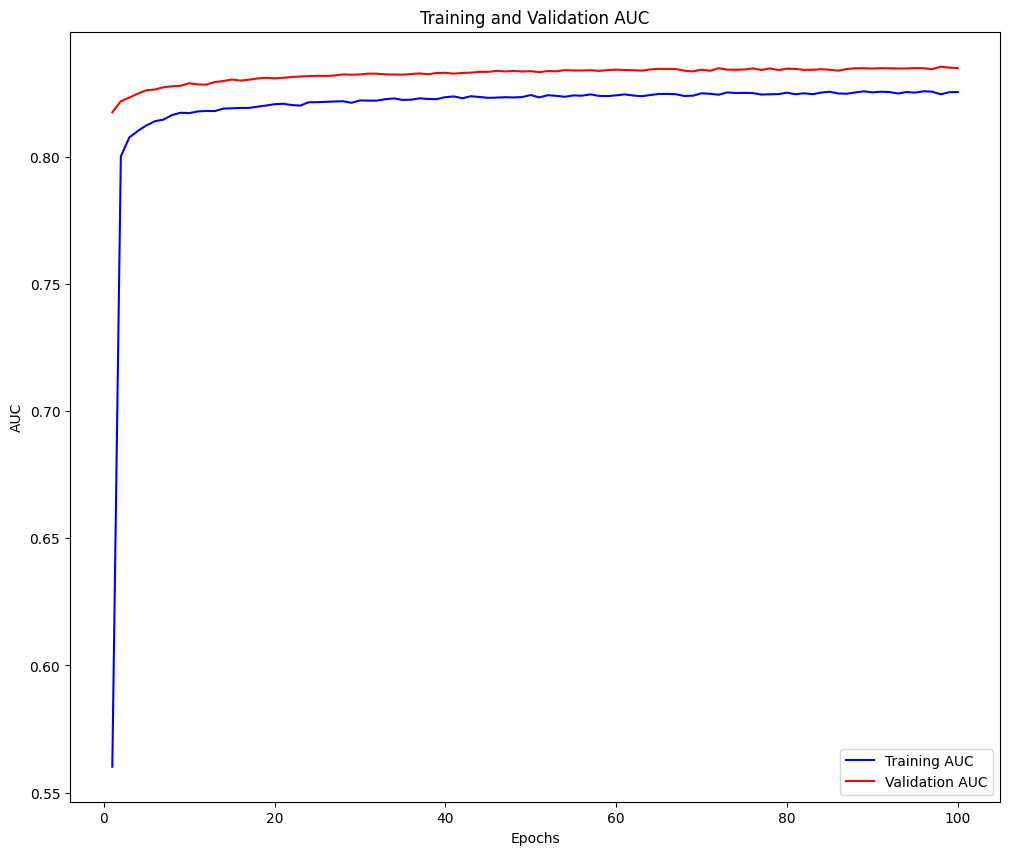

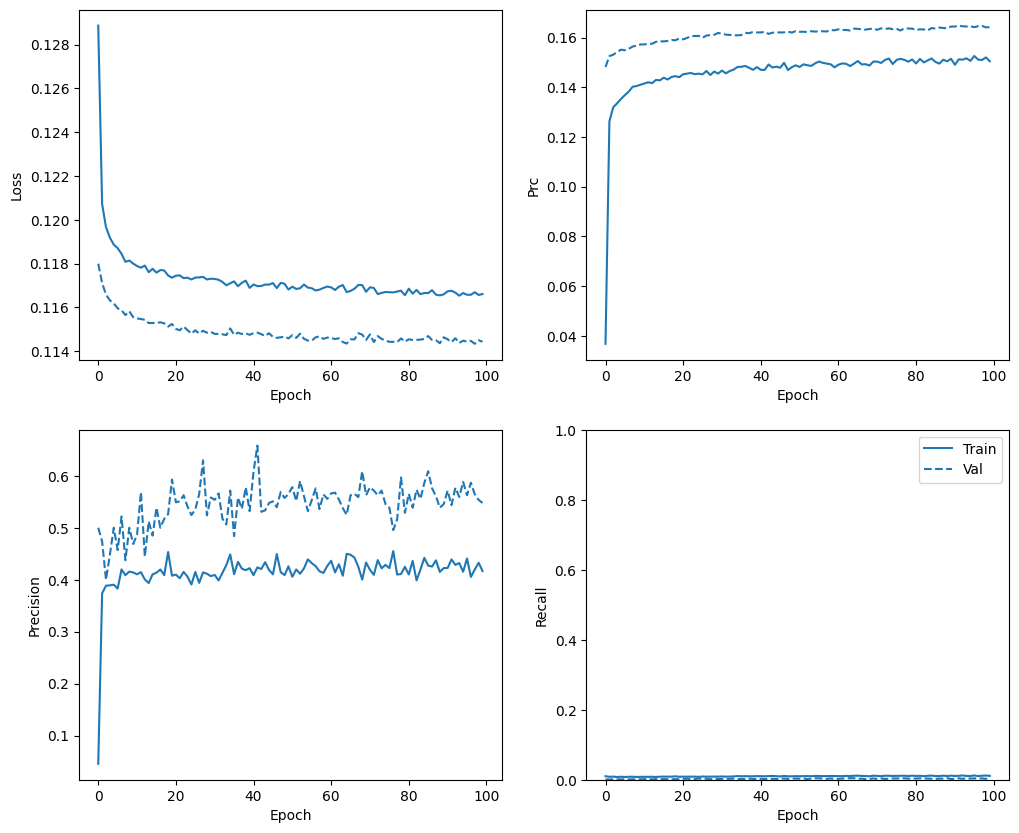

560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
HERE1
loss :  0.11441262066364288
compile_metrics :  0.028227638453245163
HERE2



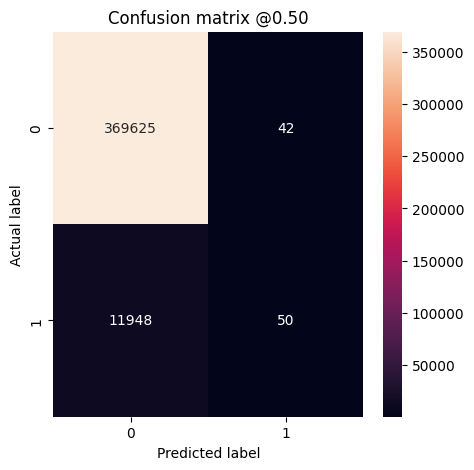

Legitimate Transactions Detected (True Negatives):  369625
Legitimate Transactions Incorrectly Detected (False Positives):  42
Fraudulent Transactions Missed (False Negatives):  11948
Fraudulent Transactions Detected (True Positives):  50
Total Fraudulent Transactions:  11998


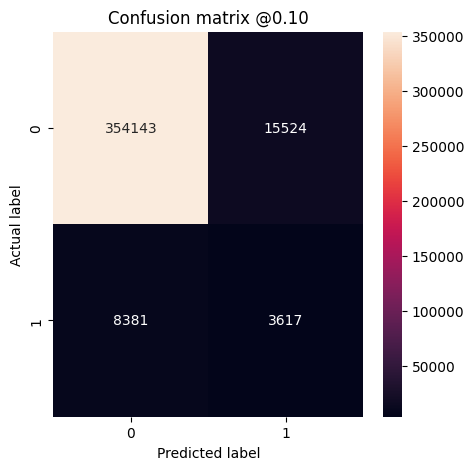

Legitimate Transactions Detected (True Negatives):  354143
Legitimate Transactions Incorrectly Detected (False Positives):  15524
Fraudulent Transactions Missed (False Negatives):  8381
Fraudulent Transactions Detected (True Positives):  3617
Total Fraudulent Transactions:  11998


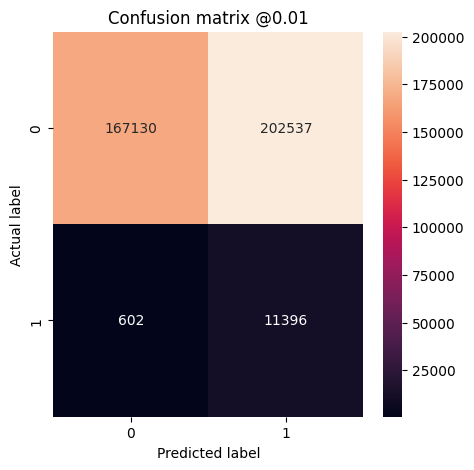

Legitimate Transactions Detected (True Negatives):  167130
Legitimate Transactions Incorrectly Detected (False Positives):  202537
Fraudulent Transactions Missed (False Negatives):  602
Fraudulent Transactions Detected (True Positives):  11396
Total Fraudulent Transactions:  11998


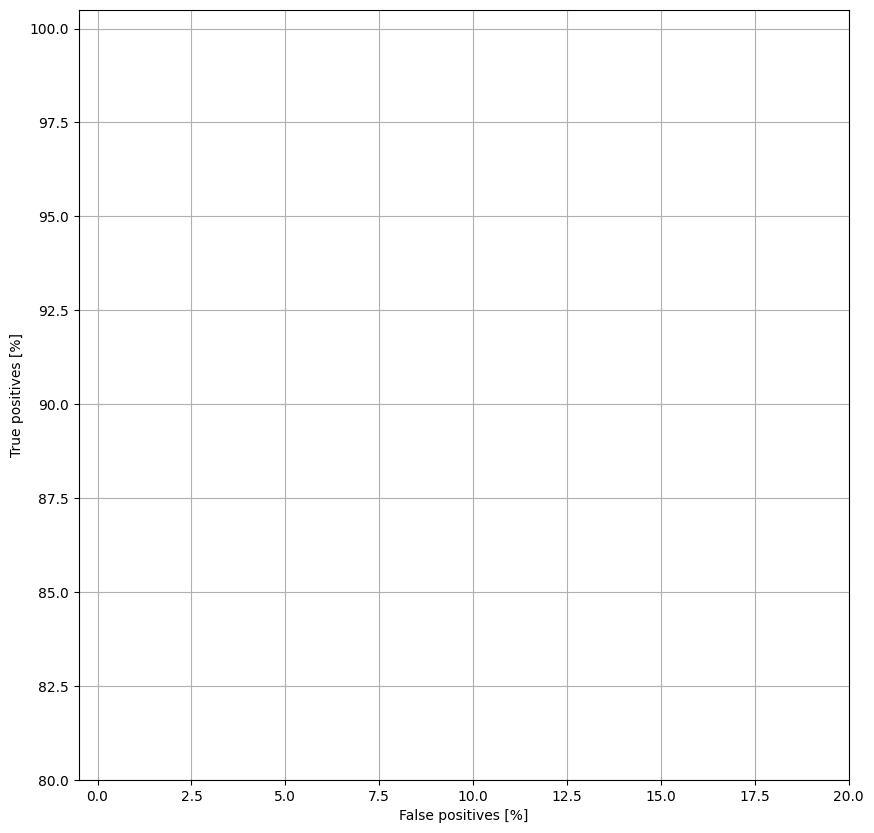

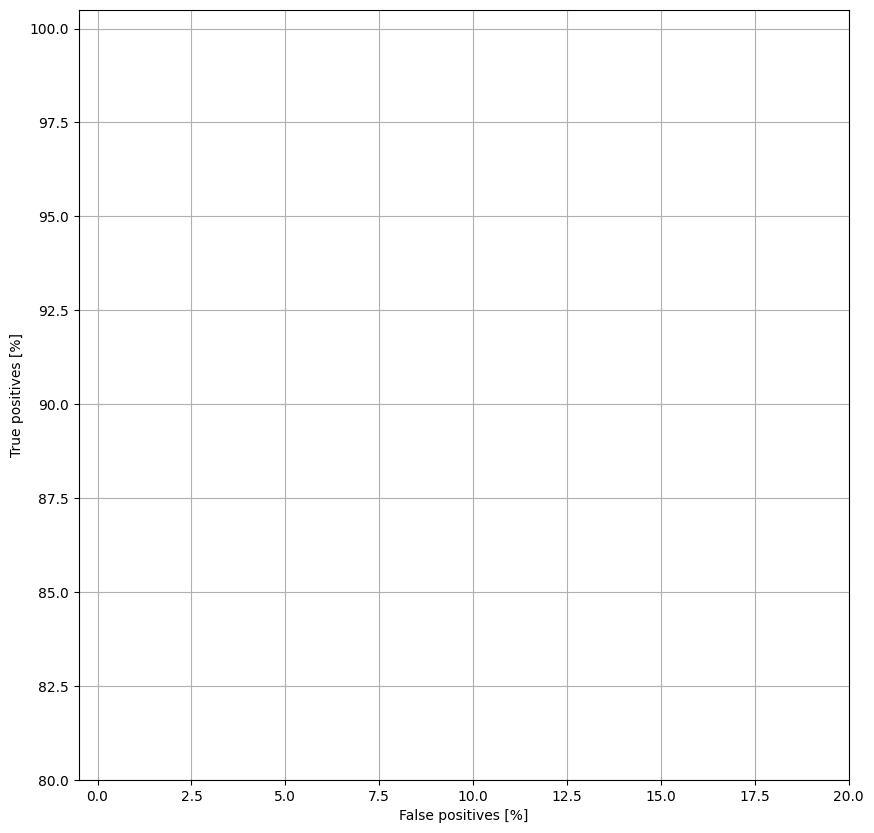

11928/11928 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
print(probabilities[0:5]) [[0.03749114]
 [0.00237816]
 [0.04128886]
 [0.03039409]
 [0.0506046 ]
 [0.00301693]
 [0.07014517]
 [0.01536609]
 [0.04005203]
 [0.02979042]]
oof [0.03749114 0.00237816 0.04128886 0.03039409 0.0506046  0.00301693
 0.07014517 0.01536609 0.04005203 0.02979042]
Fold  1 AUC : 0.836606. Elapsed time: 378.10 seconds. Remaining time: 1134.31 seconds.
FOLD  1
here  0
length  (381665, 300) (381665, 1)
here2  2
length  (763330, 300) (763330, 1)
here2  3
length  (1144994, 300) (1144994, 1)
train_x shape:  (1144994, 300)
train_y shape:  (1144994, 1)
valid_x shape:  (381665, 300)
valid_y shape:  (381665, 1)
Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent t

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │         4,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,833 (18.88 KB)

 Trainable params: 4,833 (18.88 KB)

 Non-trainable params: 0 (0.00 B)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Optional: Set the correct initial bias.These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see A Recipe for Training Neural Networks: init well. This can help with initial convergence.With the default bias initialization the loss should be about math.log(2) = 0.69314
Loss: 0.3115






MODEL 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Loss: 0.1545












MODEL 5
Epoch 1/100
 42/560 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Brier score: 0.0538 - accuracy: 0.9478 - auc: 0.5265 - cross entropy: 0.2151 - fn: 83601.5938 - fp: 58186.9297 - loss: 0.1659 - prc: 0.0322 - precision: 0.0299 - recall: 0.0210 - tn: 2572104.5000 - tp: 1791.8572

W0000 00:00:1713178862.595776      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - Brier score: 0.0501 - accuracy: 0.9510 - auc: 0.5526 - cross entropy: 0.2019 - fn: 100187.4219 - fp: 58425.4844 - loss: 0.1375 - prc: 0.0342 - precision: 0.0314 - recall: 0.0187 - tn: 3086623.2500 - tp: 1894.5758 - val_Brier score: 0.0286 - val_accuracy: 0.9686 - val_auc: 0.8168 - val_cross entropy: 0.1182 - val_fn: 11982.0000 - val_fp: 19.0000 - val_loss: 0.1180 - val_prc: 0.1515 - val_precision: 0.4722 - val_recall: 0.0014 - val_tn: 369647.0000 - val_tp: 17.0000
Epoch 2/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Brier score: 0.0288 - accuracy: 0.9686 - auc: 0.7964 - cross entropy: 0.1204 - fn: 17858.6777 - fp: 312.7701 - loss: 0.1204 - prc: 0.1238 - precision: 0.3461 - recall: 0.0090 - tn: 557138.1875 - tp: 167.9875 - val_Brier score: 0.0285 - val_accuracy: 0.9686 - val_auc: 0.8207 - val_cross entropy: 0.1171 - val_fn: 11975.0000 - val_fp: 24.0000 - val_loss: 0.1169 - val_prc: 0.1539 - val_precision: 0.5000 - val_recall: 0.0020 - val_t

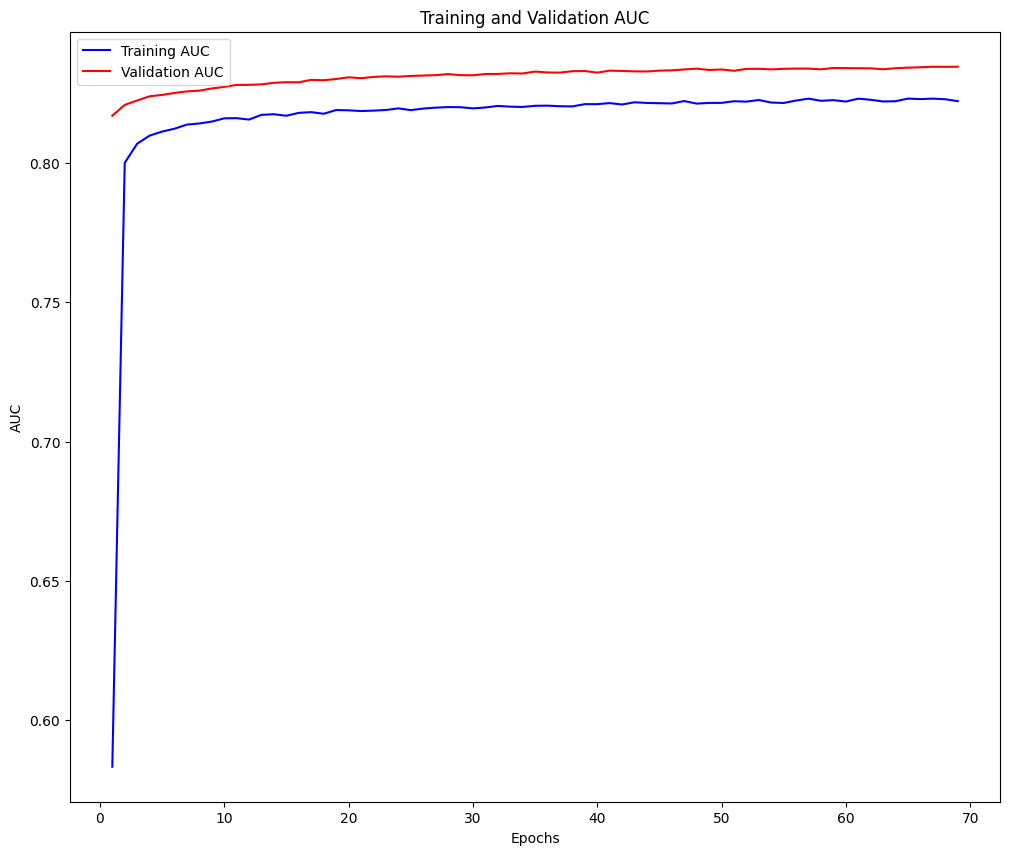

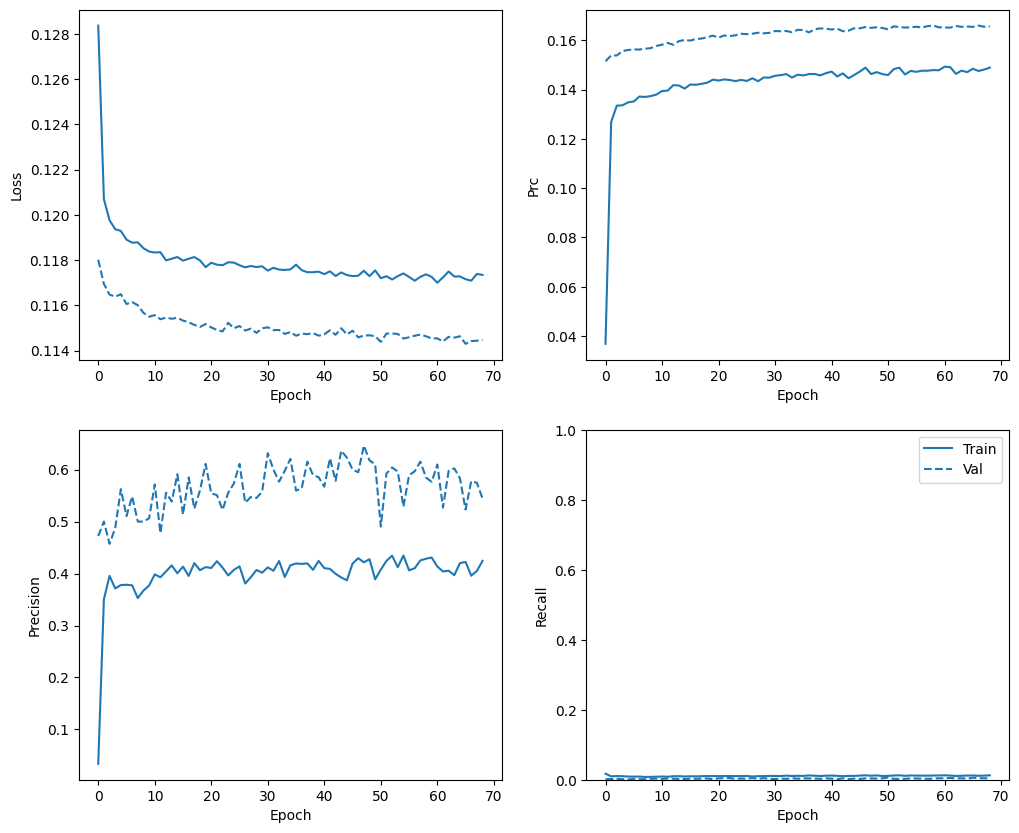

560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
HERE1
loss :  0.11463090777397156
compile_metrics :  0.028263447806239128
HERE2



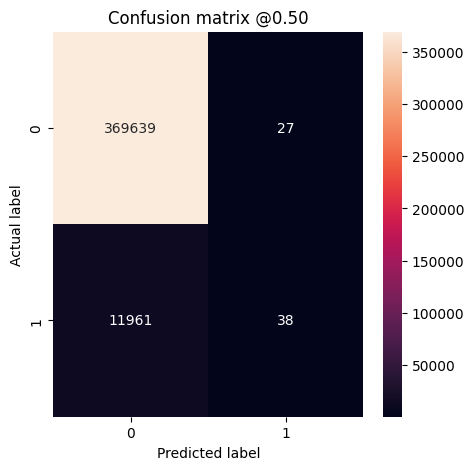

Legitimate Transactions Detected (True Negatives):  369639
Legitimate Transactions Incorrectly Detected (False Positives):  27
Fraudulent Transactions Missed (False Negatives):  11961
Fraudulent Transactions Detected (True Positives):  38
Total Fraudulent Transactions:  11999


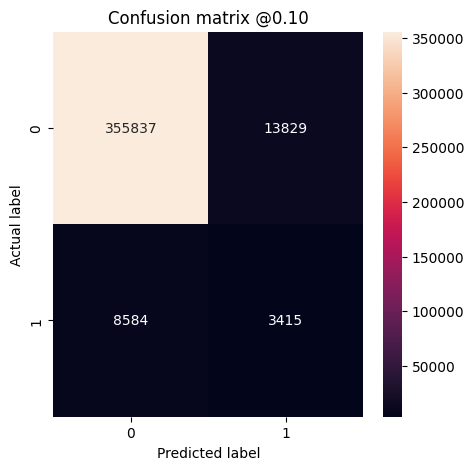

Legitimate Transactions Detected (True Negatives):  355837
Legitimate Transactions Incorrectly Detected (False Positives):  13829
Fraudulent Transactions Missed (False Negatives):  8584
Fraudulent Transactions Detected (True Positives):  3415
Total Fraudulent Transactions:  11999


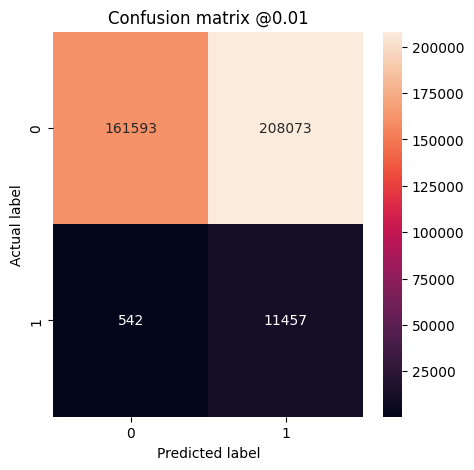

Legitimate Transactions Detected (True Negatives):  161593
Legitimate Transactions Incorrectly Detected (False Positives):  208073
Fraudulent Transactions Missed (False Negatives):  542
Fraudulent Transactions Detected (True Positives):  11457
Total Fraudulent Transactions:  11999


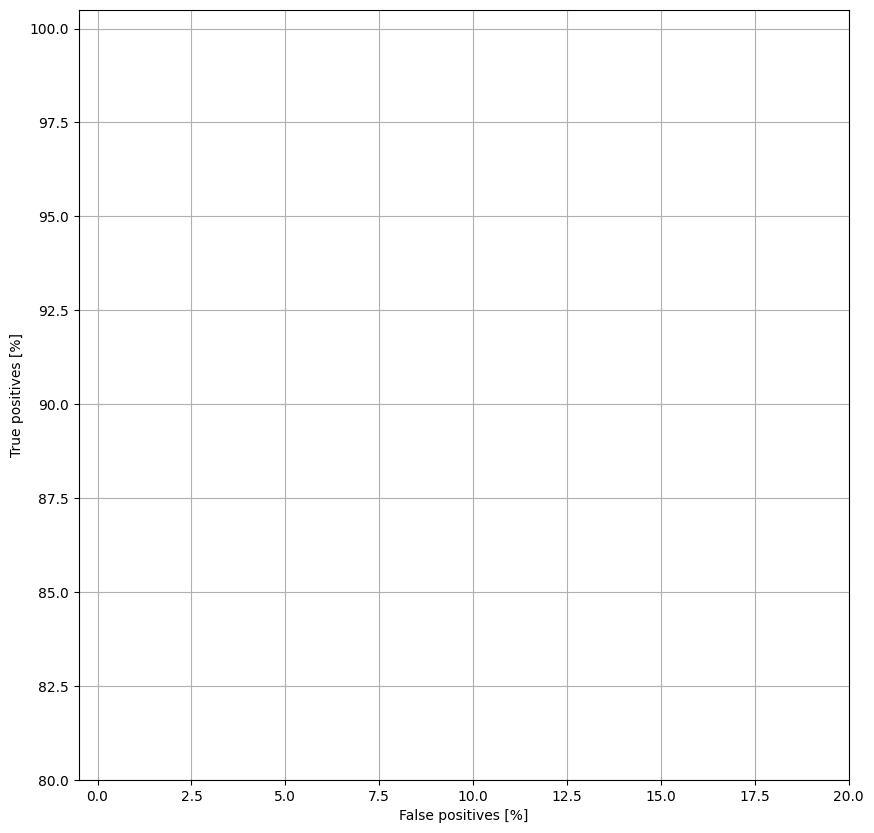

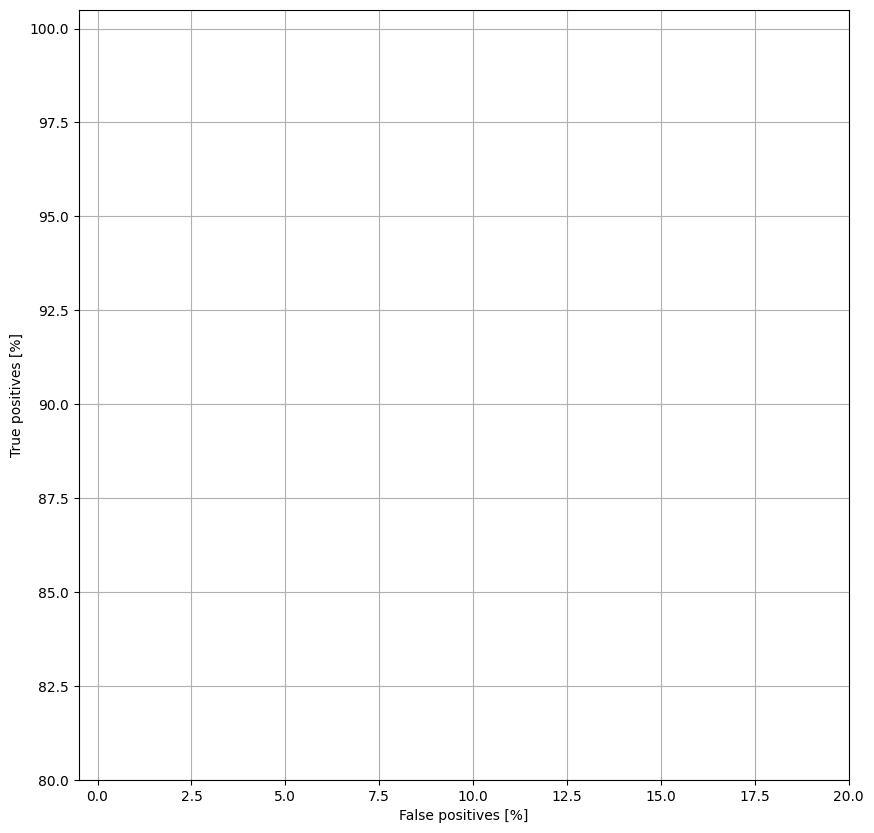

11928/11928 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
print(probabilities[0:5]) [[0.05092245]
 [0.06443983]
 [0.03552285]
 [0.04607009]
 [0.05292992]
 [0.04249064]
 [0.01794945]
 [0.02677935]
 [0.02188805]
 [0.04873879]]
oof [0.05092245 0.06443983 0.03552285 0.04607009 0.05292992 0.04249064
 0.01794945 0.02677935 0.02188805 0.04873879]
Fold  2 AUC : 0.835544. Elapsed time: 623.31 seconds. Remaining time: 623.31 seconds.
FOLD  2
here  0
length  (381665, 300) (381665, 1)
here2  1
length  (763330, 300) (763330, 1)
here2  3
length  (1144994, 300) (1144994, 1)
train_x shape:  (1144994, 300)
train_y shape:  (1144994, 1)
valid_x shape:  (381665, 300)
valid_y shape:  (381665, 1)
Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent tr

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 16)             │         4,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,833 (18.88 KB)

 Trainable params: 4,833 (18.88 KB)

 Non-trainable params: 0 (0.00 B)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Optional: Set the correct initial bias.These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see A Recipe for Training Neural Networks: init well. This can help with initial convergence.With the default bias initialization the loss should be about math.log(2) = 0.69314
Loss: 2.2977






MODEL 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Loss: 0.1781












MODEL 5
Epoch 1/100
 41/560 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Brier score: 0.3411 - accuracy: 0.5721 - auc: 0.5305 - cross entropy: 1.0637 - fn: 49198.3906 - fp: 1112210.6250 - loss: 0.2028 - prc: 0.0357 - precision: 0.0315 - recall: 0.4238 - tn: 1517067.7500 - tp: 36184.2188

W0000 00:00:1713179106.895447      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - Brier score: 0.2930 - accuracy: 0.6335 - auc: 0.5465 - cross entropy: 0.9195 - fn: 65843.7031 - fp: 1112756.0000 - loss: 0.1481 - prc: 0.0362 - precision: 0.0316 - recall: 0.3592 - tn: 2032216.2500 - tp: 36314.7422 - val_Brier score: 0.0287 - val_accuracy: 0.9686 - val_auc: 0.8148 - val_cross entropy: 0.1188 - val_fn: 11975.0000 - val_fp: 27.0000 - val_loss: 0.1187 - val_prc: 0.1467 - val_precision: 0.4706 - val_recall: 0.0020 - val_tn: 369639.0000 - val_tp: 24.0000
Epoch 2/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - Brier score: 0.0291 - accuracy: 0.9682 - auc: 0.7949 - cross entropy: 0.1216 - fn: 17936.2285 - fp: 375.2977 - loss: 0.1216 - prc: 0.1257 - precision: 0.3591 - recall: 0.0117 - tn: 556954.9375 - tp: 211.1836 - val_Brier score: 0.0286 - val_accuracy: 0.9686 - val_auc: 0.8197 - val_cross entropy: 0.1175 - val_fn: 11972.0000 - val_fp: 31.0000 - val_loss: 0.1174 - val_prc: 0.1512 - val_precision: 0.4655 - val_recall: 0.0023 - val

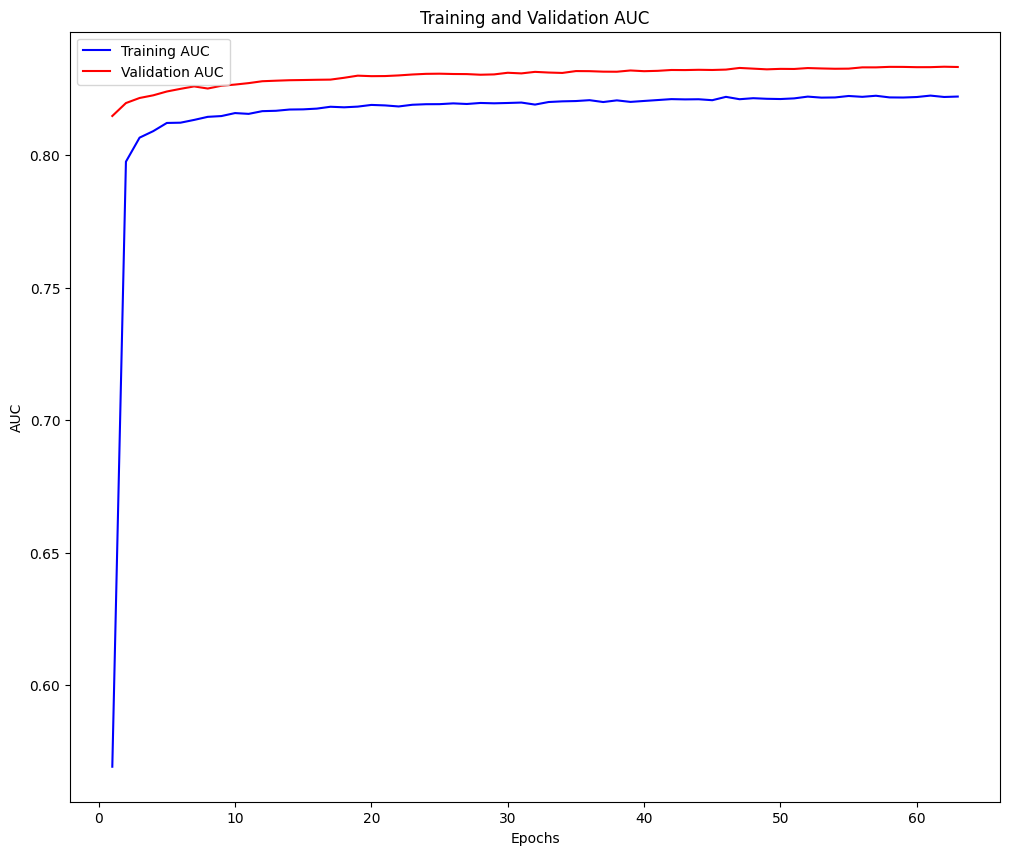

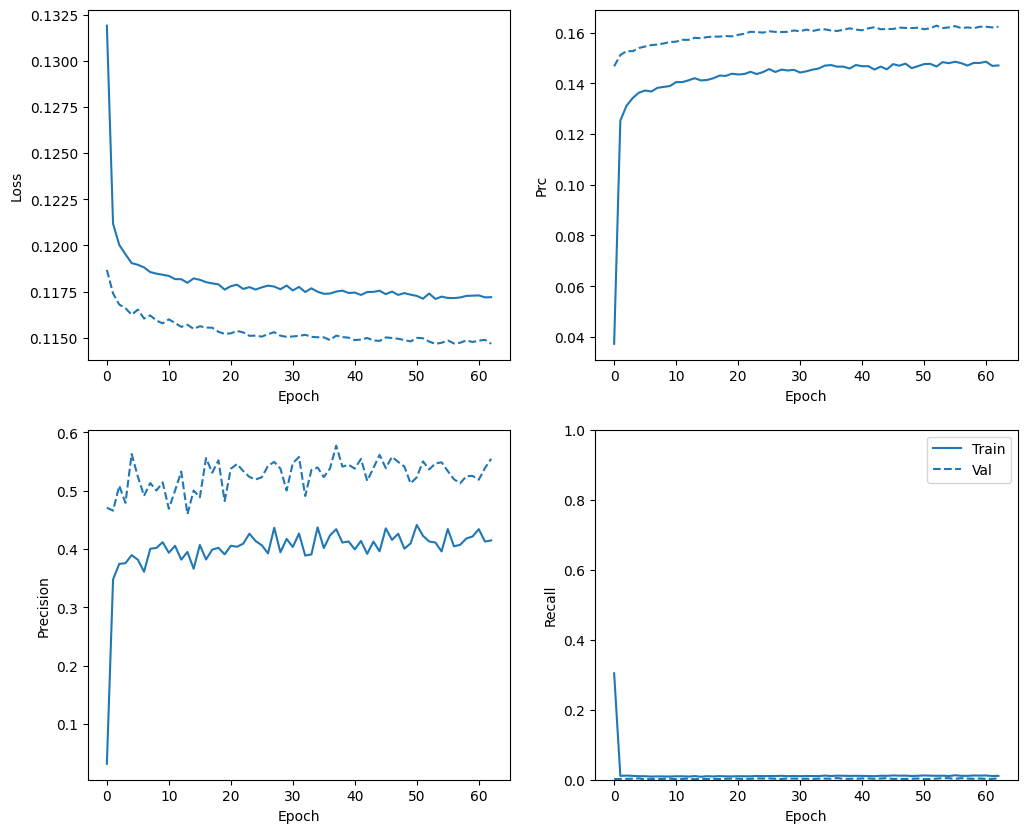

560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
HERE1
loss :  0.11478817462921143
compile_metrics :  0.028283709660172462
HERE2



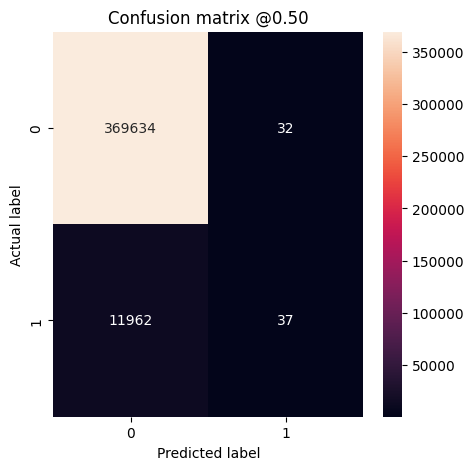

Legitimate Transactions Detected (True Negatives):  369634
Legitimate Transactions Incorrectly Detected (False Positives):  32
Fraudulent Transactions Missed (False Negatives):  11962
Fraudulent Transactions Detected (True Positives):  37
Total Fraudulent Transactions:  11999


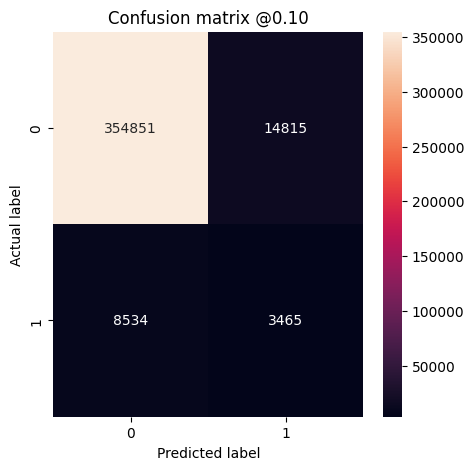

Legitimate Transactions Detected (True Negatives):  354851
Legitimate Transactions Incorrectly Detected (False Positives):  14815
Fraudulent Transactions Missed (False Negatives):  8534
Fraudulent Transactions Detected (True Positives):  3465
Total Fraudulent Transactions:  11999


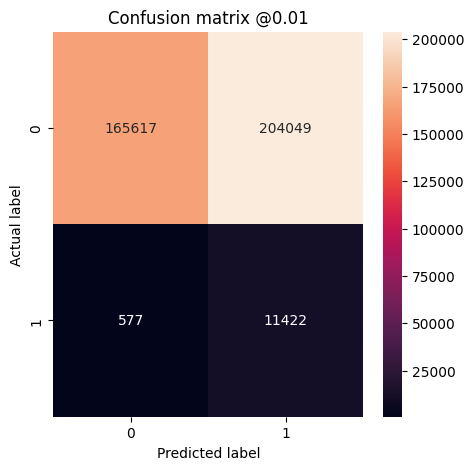

Legitimate Transactions Detected (True Negatives):  165617
Legitimate Transactions Incorrectly Detected (False Positives):  204049
Fraudulent Transactions Missed (False Negatives):  577
Fraudulent Transactions Detected (True Positives):  11422
Total Fraudulent Transactions:  11999


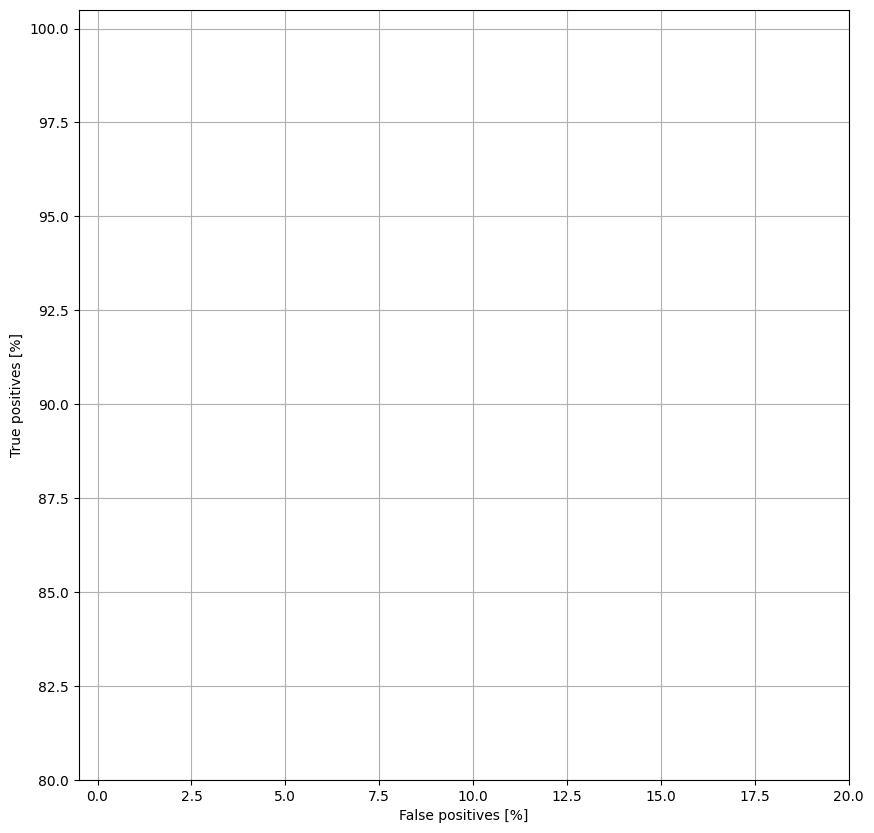

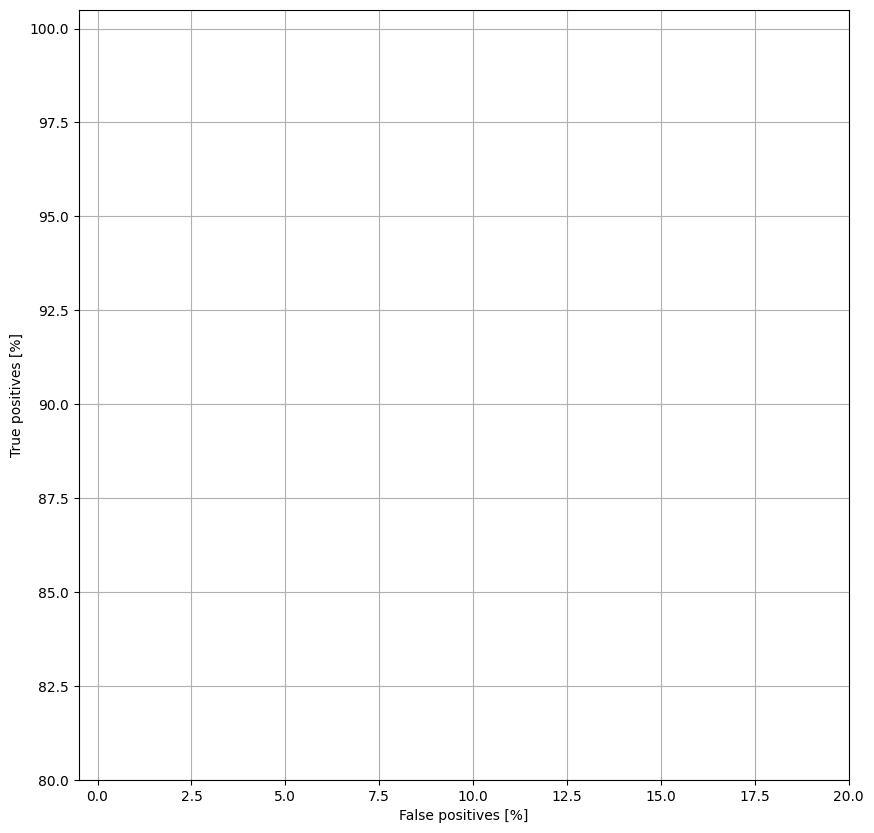

11928/11928 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
print(probabilities[0:5]) [[0.03848025]
 [0.05648531]
 [0.01601288]
 [0.02774567]
 [0.0097706 ]
 [0.01742976]
 [0.02856563]
 [0.01985316]
 [0.04989314]
 [0.03357618]]
oof [0.03848025 0.05648531 0.01601288 0.02774567 0.0097706  0.01742976
 0.02856563 0.01985316 0.04989314 0.03357618]
Fold  3 AUC : 0.834507. Elapsed time: 856.81 seconds. Remaining time: 285.60 seconds.
FOLD  3
here  0
length  (381665, 300) (381665, 1)
here2  1
length  (763330, 300) (763330, 1)
here2  2
length  (1144995, 300) (1144995, 1)
train_x shape:  (1144995, 300)
train_y shape:  (1144995, 1)
valid_x shape:  (381664, 300)
valid_y shape:  (381664, 1)
Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent tr

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 16)             │         4,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,833 (18.88 KB)

 Trainable params: 4,833 (18.88 KB)

 Non-trainable params: 0 (0.00 B)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Optional: Set the correct initial bias.These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see A Recipe for Training Neural Networks: init well. This can help with initial convergence.With the default bias initialization the loss should be about math.log(2) = 0.69314
Loss: 1.4879






MODEL 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Loss: 0.1704












MODEL 5
Epoch 1/100
 43/560 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Brier score: 0.2247 - accuracy: 0.6808 - auc: 0.5149 - cross entropy: 0.7176 - fn: 59343.9531 - fp: 807630.7500 - loss: 0.1680 - prc: 0.0324 - precision: 0.0312 - recall: 0.3050 - tn: 1823695.5000 - tp: 26040.8145

W0000 00:00:1713179342.885228      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - Brier score: 0.1946 - accuracy: 0.7253 - auc: 0.5343 - cross entropy: 0.6272 - fn: 75989.7812 - fp: 807773.3750 - loss: 0.1408 - prc: 0.0337 - precision: 0.0313 - recall: 0.2583 - tn: 2337276.2500 - tp: 26093.3320 - val_Brier score: 0.0287 - val_accuracy: 0.9686 - val_auc: 0.8149 - val_cross entropy: 0.1185 - val_fn: 11994.0000 - val_fp: 3.0000 - val_loss: 0.1186 - val_prc: 0.1437 - val_precision: 0.5714 - val_recall: 3.3339e-04 - val_tn: 369663.0000 - val_tp: 4.0000
Epoch 2/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - Brier score: 0.0291 - accuracy: 0.9684 - auc: 0.7981 - cross entropy: 0.1211 - fn: 17981.2520 - fp: 210.9661 - loss: 0.1211 - prc: 0.1239 - precision: 0.3760 - recall: 0.0072 - tn: 557157.3125 - tp: 128.0695 - val_Brier score: 0.0286 - val_accuracy: 0.9686 - val_auc: 0.8200 - val_cross entropy: 0.1177 - val_fn: 11994.0000 - val_fp: 2.0000 - val_loss: 0.1178 - val_prc: 0.1486 - val_precision: 0.6667 - val_recall: 3.3339e-04 -

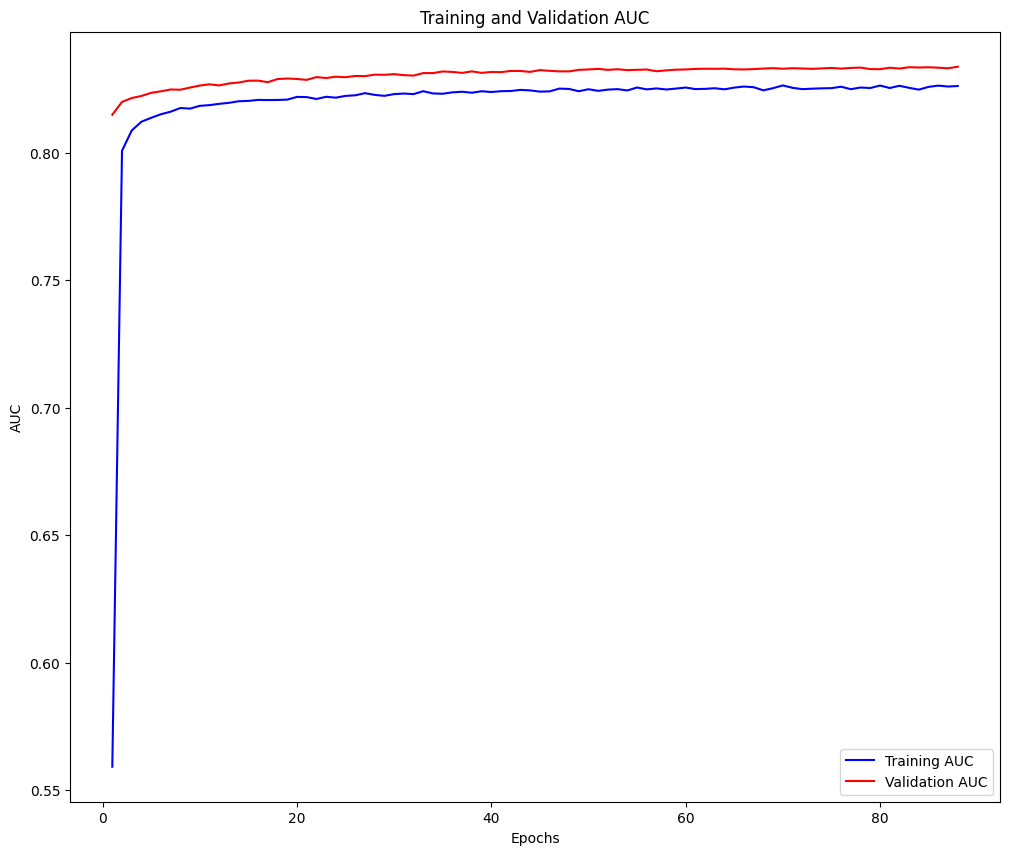

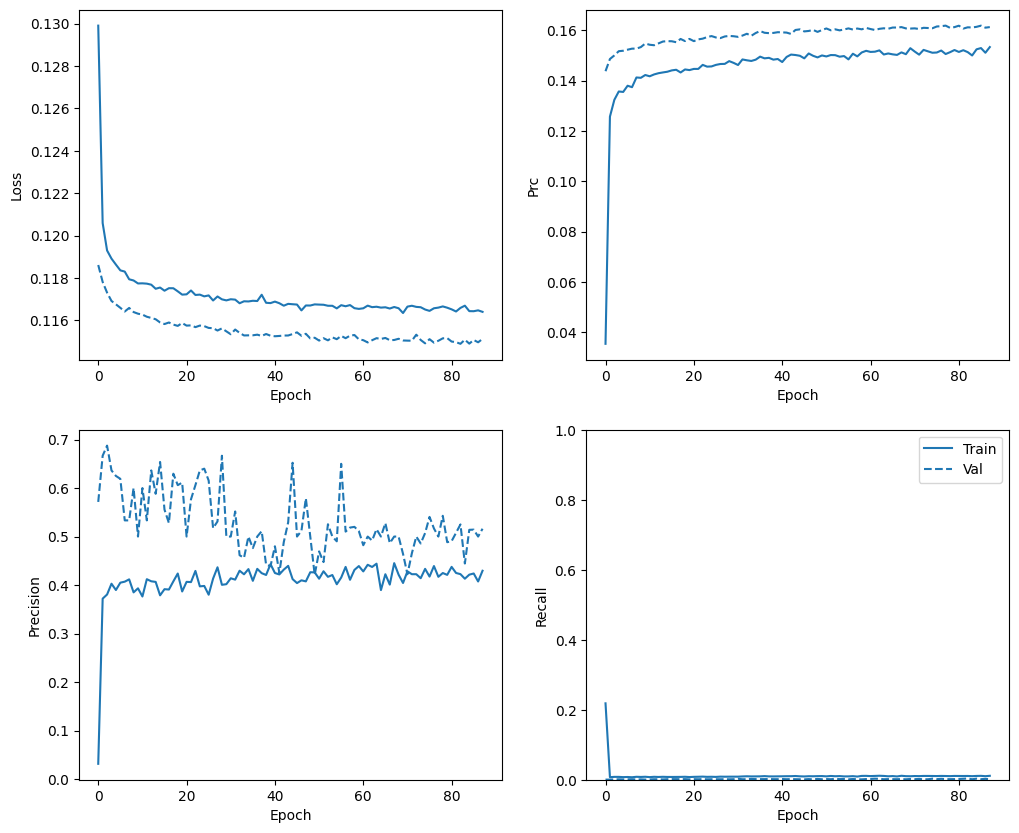

560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
HERE1
loss :  0.11503349244594574
compile_metrics :  0.028300775215029716
HERE2



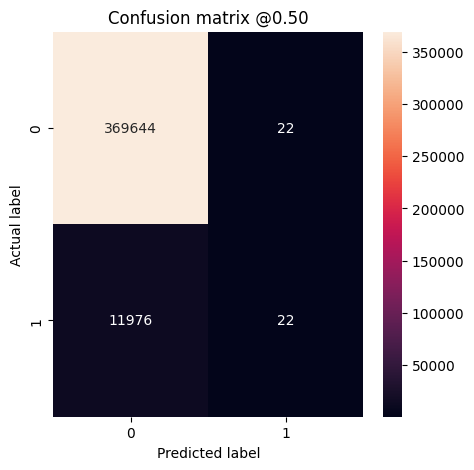

Legitimate Transactions Detected (True Negatives):  369644
Legitimate Transactions Incorrectly Detected (False Positives):  22
Fraudulent Transactions Missed (False Negatives):  11976
Fraudulent Transactions Detected (True Positives):  22
Total Fraudulent Transactions:  11998


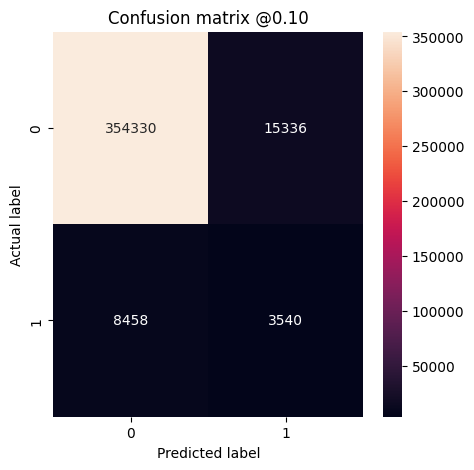

Legitimate Transactions Detected (True Negatives):  354330
Legitimate Transactions Incorrectly Detected (False Positives):  15336
Fraudulent Transactions Missed (False Negatives):  8458
Fraudulent Transactions Detected (True Positives):  3540
Total Fraudulent Transactions:  11998


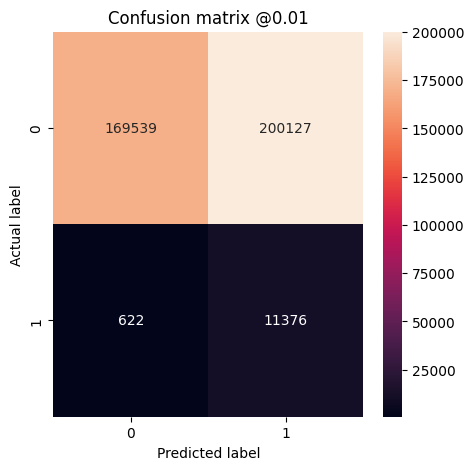

Legitimate Transactions Detected (True Negatives):  169539
Legitimate Transactions Incorrectly Detected (False Positives):  200127
Fraudulent Transactions Missed (False Negatives):  622
Fraudulent Transactions Detected (True Positives):  11376
Total Fraudulent Transactions:  11998


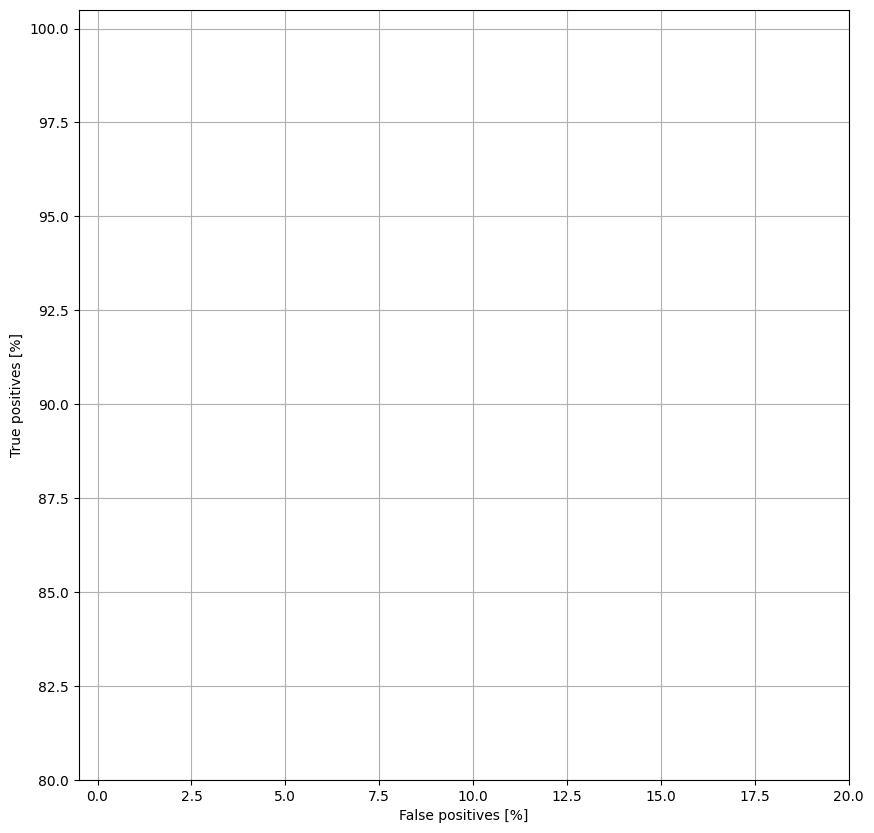

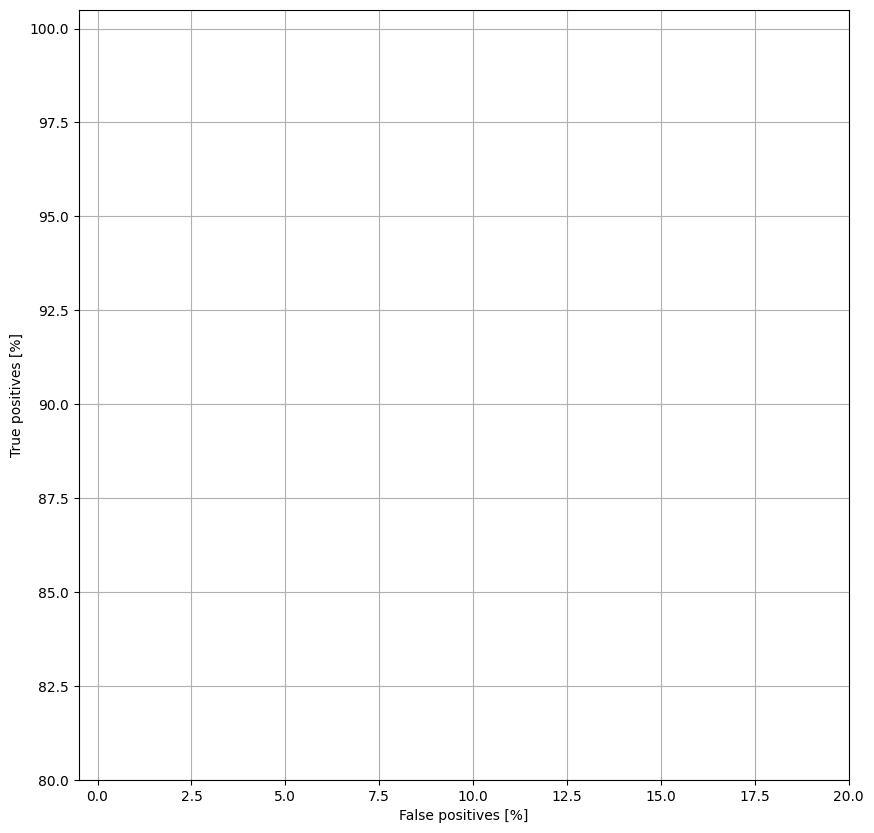

11927/11927 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
print(probabilities[0:5]) [[0.04375067]
 [0.07284341]
 [0.02230415]
 [0.04963893]
 [0.01208371]
 [0.0207281 ]
 [0.00435809]
 [0.02382638]
 [0.05001075]
 [0.0130405 ]]
oof [0.04375067 0.07284341 0.02230415 0.04963893 0.01208371 0.0207281
 0.00435809 0.02382638 0.05001075 0.0130405 ]
Fold  4 AUC : 0.835164. Elapsed time: 1163.12 seconds. Remaining time: 0.00 seconds.
Full AUC score 0.835404
Gini Score of the valid set: 0.6501567124272191
Model training - done in 1172s


Predicting:   0%|          | 0/4 [00:00<?, ? models/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Submission file has been created.
Submission - done in 9s
NOTEBOOK HAS BEEN SUCCESSFULLY EXECUTED !!!
Pipeline total time - done in 3948s


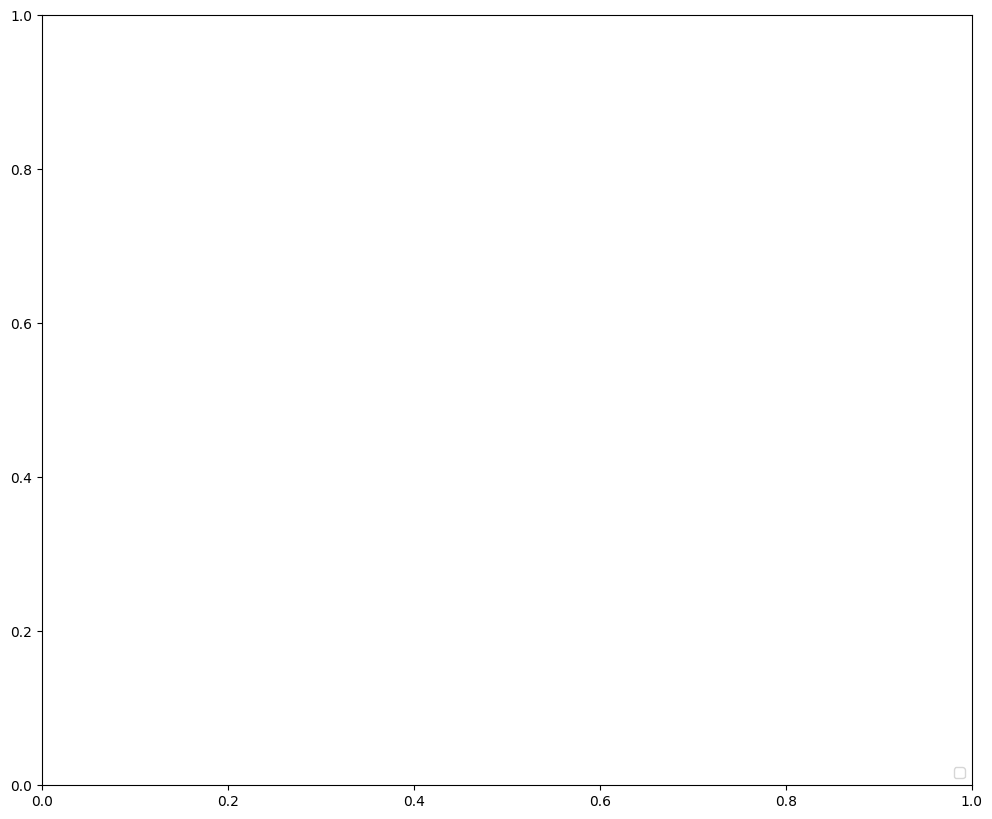

In [39]:

if __name__ == "__main__":
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.max_columns', 100)
    with timer("Pipeline total time"):
        main(debug= False)